# PRODUCTIVIDAD_beta

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import dateparser 
import matplotlib.pyplot as plt

import seaborn as sns

import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize

from datetime import datetime, timedelta,date
%matplotlib inline

import timeit
import warnings

plt.style.use('seaborn-white')

pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 20})

sns.set_context("paper", font_scale=2.5)  


#########################################                            ########################################




########################################          PRODUCTIVIDAD     #########################################




########################################                            #########################################






##################    CARGA DE BASE DE DATOS DE CNH   ######################

def carga_bd():
    
    global mx_bd
    global mx_reservas
    global mx_tiempos
    
    tic=timeit.default_timer()
    
    mx_bd=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_full.csv',
                          usecols=['fecha',
                                  'pozo',
                                  'aceite_Mbd',
                                  'gas_asociado_MMpcd',
                                  'gas_no_asociado_MMpcd',
                                  'condensado_Mbd',
                                  'agua_Mbd',
                                  'estado_actual',
                                  'profundidad_total',
                                  'profundidad_vertical',
                                  'trayectoria', 
                                  'ano_de_perforacion',
                                  'tipo_de_hidrocarburo',
                                  'clasificacion',
                                  'disponible',
                                  'campo',
                                  'cuenca', 
                                  'entidad',  
                                  'ubicacion',
                                  'contrato'],
                                  low_memory=True)
            
    mx_reservas=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_reservas.csv',
                          index_col=0)
    
    mx_tiempos=pd.read_csv("/Users/fffte/ainda_drive/python/csv/benchmark/mexico/mx_tiempos.csv",
                          index_col=0,
                          parse_dates=True)
    
    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds

    return display('Tiempo de procesamiento: ' +str(tac)+' segundos')


##################    FUNCIÓN DE PRODUCTIVIDAD   ######################

def productividad():
    
    global perfil
    global df
    global tipo1
    global tipo2
    global tipo3
    global parametros
    global tipos
    
    tic=timeit.default_timer()
    
    global alta, media, baja
    
    alta=0.90
    media=0.50
    baja=0.30
    
##################    INPUT CAMPO   ######################
    
    #input de campo de analisis
    def campo_analisis():
        
        global input_campo, input_hidrocarburo, input_fecha, input_analogos
        global pozos, analogos
        global len_proy, len_perfil
        global nequip
        global cap
        global reservas_aceite, info_reservas
        global num_pozos
        global pozos_tipo1,pozos_tipo2,pozos_tipo3
        global regimen_fiscal, regalia_adicional, region_fiscal
        global lista_pozos
        global info_tiempos, tiempos_campo
        
        
        ####################        SECCION DE INPUTS          #####################
        
        #INPUT DE CAMPO
        
        input_campo = str(input("Nombre de campo: "))
        
        #INPUT DE ANALOGOS
        
        input_analogos=input("Analisis DCA Analogos (Y/''): ")
        input_analogos=str(input_analogos)
        
        if input_analogos == str(''):
            input_analogos='N'

        #INPUT DE RANGO DE MUESTRA
        
        input_fecha=input("Tomar muestra desde fecha (yyyy-mm-dd): ")

        if input_fecha == str(''):
            input_fecha='2000-01-01'
            
        input_fecha=pd.Timestamp(input_fecha)
        
        #INPUTS ECONOMICOS
        
        #Regimen Fiscal especificar si es "licencia", "cpc" o "asignacion" 
        regimen_fiscal = input("Régimen Fiscal: ") #"licencia"
        regimen_fiscal = str(regimen_fiscal)
        
        if regimen_fiscal == str(''):
            regimen_fiscal = 'licencia'
        
        if regimen_fiscal not in ["licencia","cpc","asignacion"]:
             raise SystemExit("Párametro Inválido")

        if regimen_fiscal == "licencia":
            regalia_adicional = input("Regalía Adicional Decimales: ") #En decimales el porcentaje de regalía adicional para los contratos de licencia
            
            if regalia_adicional == str(''):
                regalia_adicional = float(0.10)
            else:
                regalia_adicional = float(regalia_adicional)

        #Region fiscal: aceite_terrestre, aguas_someras, aguas_profundas, gas, chicontepec 
        #region_fiscal =  input("Región Fiscal: ") #"aceite_terrestre"   
        #region_fiscal=str(region_fiscal)
        #if region_fiscal not in ["aceite_terrestre","aguas_someras","aguas_profundas","gas","chicontepec"]:
         #   raise SystemExit("Párametro Inválido")
            
        ####################        SUBSET DE LA BASE CAMPO ANALISIS         #####################
        
        pozos=pd.DataFrame()
        
        seleccion_pozo=mx_bd.pozo.str.contains(pat=input_campo,regex=True)
        seleccion_campo=mx_bd.campo.str.match(pat=input_campo)
        pozos=mx_bd.loc[seleccion_campo & seleccion_pozo]
        
        seleccion_reservas=mx_reservas.NOMBRE.str.match(pat=input_campo)
        info_reservas=mx_reservas.loc[seleccion_reservas]
        #info_reservas=mx_reservas[mx_reservas.NOMBRE == str(input_campo)]
        
        seleccion_tiempos=mx_tiempos.campo.str.match(pat=input_campo)
        seleccion_tiempos=seleccion_tiempos.fillna(value=False)
        info_tiempos=mx_tiempos.loc[seleccion_tiempos]
        tiempos_campo=info_tiempos[info_tiempos.dias_perforacion < info_tiempos.dias_perforacion.quantile(0.90)]

        lista_pozos=list(pd.unique(pozos['pozo']))

        display('Número de pozos en ' +str(input_campo)+': '+str(len(lista_pozos)))
        
        ####################        VALIDACION REGION FISCAL         #####################
        
        if pozos.cuenca.str.contains('TAMPICO-MISANTLA').any() == True:
                region_fiscal = 'chicontepec'
        
        if pozos.cuenca.str.contains('VERACRUZ').any() == True:
            if pozos.tipo_de_hidrocarburo.str.contains('GAS').any() == True: 
                region_fiscal = 'gas'
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.cuenca.str.contains('BURGOS' or 'SABINAS').any() == True:
            if pozos.tipo_de_hidrocarburo.str.contains('GAS').any() == True:
                region_fiscal = 'gas' 
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.cuenca.str.contains('CUENCAS DEL SURESTE').any() == True:
            if pozos.ubicacion.str.contains('MARINO').any() == True:
                region_fiscal = 'aguas_someras'
            else:
                region_fiscal = 'aceite_terrestre'

        if pozos.ubicacion.str.contains('AGUAS PROFUNDAS').any() == True :
            region.fiscal = 'aguas_profundas'

        if pozos.cuenca.str.contains('CINTURON PLEGADO DE CHIAPAS').any() == True:
            region.fiscal = 'aceite_terrestre'

        if region_fiscal not in ["aceite_terrestre","aguas_someras","aguas_profundas","gas","chicontepec"]:
            raise SystemExit("Párametro Inválido")
    
    
         #ARCHIVO CSV CON BASE DE DATOS DE POZOS
        #pozos.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))
        
        
        ####################        INPUTS VARIABLES DE EVALUACION         #####################
        
        #duracion=int(input('Duracion del contrato (años): '))
        #nequip=input('Numero de equipos: ')
        #cap=input('Capacidad de procesamiento (Mbd: ')
        #reservas=input('Reservas: ')
        
        len_proy=0
        len_perfil=20*12
        duracion=30
        len_proy=duracion*12
        num_pozos=6
        nequip=1
        cap=1_000
        reservas_aceite=float(info_reservas['CRUDO 2P (MMB)'].sum())
        reservas_gas=float(info_reservas['GAS NATURAL 2P (MMBPCE)'].sum())
        
        pozos_tipo1=np.round(num_pozos*baja,0)
        pozos_tipo2=np.round(num_pozos*media,0)
        pozos_tipo3=num_pozos-(pozos_tipo1+pozos_tipo2)

        return len_proy, nequip, cap, reservas_aceite, num_pozos
        
    
#############     ANÁLISIS DE DECLINACION DE POZOS (DCA)   #############

    def analisis_dca():
        
        global unique_well_list
        global serie_campo, serie_muestra, serie_status
        global serie_base, Q_base, G_base, C_base
        global hidrocarburo, gas, condensado
        global gasto
        global estadistica, resumen, resumen_produccion, produccion_mensual
        
        def remove_nan_and_zeroes_from_columns(df, variable):
            """
            This function cleans up a dataframe by removing rows in a specific 
            column that are null/NaN or equal to 0. This basically removes zero 
            production time periods.
            Arguments:
            df: Pandas dataframe.
            variable: String. Name of the column where we want to filter out
            NaN's or 0 values
            Output:
            filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
            the specified column
            """
            filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
            return filtered_df

        def generate_time_delta_column(df, time_column, date_first_online_column):
            """
            Create column for the time that a well has been online at each reading, with 
            the first non-null month in the series listed as the start of production
            Arguments:
            df: Pandas dataframe
            time_column: String. Name of the column that includes the specific record date
            that the data was taken at. Column type is pandas datetime
            date_first_online_column: Name of the column that includes the date that the
            well came online. Column type is pandas datetime
            Outputs:
            Pandas series containing the difference in days between the date the well
            came online and the date that the data was recorded (cumulative days online)
            """
            df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
            return (df[time_column]-df[date_first_online_column]).dt.days

        def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):

            """
            This function obtains the min or max value for a column, with a group by applied. For example,
            it could return the earliest (min) RecordDate for each API number in a dataframe 
            Arguments:
            dataframe: Pandas dataframe 
            group_by_column: string. Name of column that we want to apply a group by to
            calc_column: string. Name of the column that we want to get the aggregated max or min for
            calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
            or the max value for the aggregated column
            Outputs:
            value: Depends on the calc_column type.
            """
            value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
            return value

        def get_max_initial_production(df, number_first_months, variable_column, date_column):

            """
            This function allows you to look at the first X months of production, and selects 
            the highest production month as max initial production
            Arguments:
            df: Pandas dataframe. 
            number_first_months: float. Number of months from the point the well comes online
            to compare to get the max initial production rate qi (this looks at multiple months
            in case there is a production ramp-up)
            variable_column: String. Column name for the column where we're attempting to get
            the max volume from (can be either 'Gas' or 'Oil' in this script)
            date_column: String. Column name for the date that the data was taken at 
            """
            #First, sort the data frame from earliest to most recent prod date
            df=df.sort_values(by=date_column)
            #Pull out the first x months of production, where number_first_months is x
            df_beginning_production=df.head(number_first_months)
            #Return the max value in the selected variable column from the newly created 
            #df_beginning_production df
            return df_beginning_production[variable_column].max()

        def hiperbolica(t, qi, b, di):
            """
            Hyperbolic decline curve equation
            Arguments:
            t: Float. Time since the well first came online, can be in various units 
            (days, months, etc) so long as they are consistent.
            qi: Float. Initial production rate when well first came online.
            b: Float. Hyperbolic decline constant
            di: Float. Nominal decline rate at time t=0
            Output: 
            Returns q, or the expected production rate at time t. Float.
            """
            return qi/((1.0+b*di*t)**(1.0/b))

        def exponencial(t, qi, di):
            """
            Exponential decline curve equation
            Arguments:
            t: Float. Time since the well first came online, can be in various units 
            (days, months, etc) so long as they are consistent.
            qi: Float. Initial production rate when well first came online.
            di: Float. Nominal decline rate (constant)
            Output: 
            Returns q, or the expected production rate at time t. Float.
            """
            return qi*np.exp(-di*t)

        def harmonica(t, qi, di):
            """
            Harmonic decline curve equation
            Arguments:
            t: Float. Time since the well first came online, can be in various units 
            (days, months, etc) so long as they are consistent.
            qi: Float. Initial production rate when well first came online.
            di: Float. Nominal decline rate (constant)
            Output: 
            Returns q, or the expected production rate at time t. Float.
            """
            return qi/(1+(di*t))

        def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
            """
            This function is used to map x- and y-variables against each other
            Arguments:
            df: Pandas dataframe.
            x_variable: String. Name of the column that we want to set as the 
            x-variable in the plot
            y_variables: string (single), or list of strings (multiple). Name(s) 
            of the column(s) that we want to set as the y-variable in the plot
            """
            #Plot serie_campo
            df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
            plt.show()
        
        serie_campo=pd.DataFrame()
        serie_muestra=pd.DataFrame()
        serie_base=pd.DataFrame()
        serie_status=pd.DataFrame()
        Qi=pd.DataFrame()
        gasto=pd.DataFrame()
        
        #Carga data pozos
        data_pozos=pozos
        
        #Limpieza de datos y formato de fecha
        data_pozos['fecha']=pd.to_datetime(data_pozos['fecha'])
        
        #Hidrocarburos de análisis
        if data_pozos.aceite_Mbd.sum() > data_pozos.gas_no_asociado_MMpcd.sum():
            
            hidrocarburo='aceite_Mbd'
            gas='gas_asociado_MMpcd'
            
        else:
            
            hidrocarburo='gas_no_asociado_MMpcd'
            gas='gas_no_asociado_MMpcd'
        
        condensado='condensado_Mbd'
        
        #Remove all rows with null values in the desired time series column
        data_pozos=remove_nan_and_zeroes_from_columns(data_pozos, hidrocarburo)
        
        #Get a list of unique wells to loop through
        unique_well_list=list(pd.unique(data_pozos.pozo))
        
        #Get the earliest RecordDate for each Well
        data_pozos['first_oil']= get_min_or_max_value_in_column_by_group(data_pozos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')
        
        
        #Generate column for time online delta
        data_pozos['days_online']=generate_time_delta_column(data_pozos, time_column='fecha', 
                      date_first_online_column='first_oil')
        
        
        #Generacion de dataframes por rangos de fechas de análisis
        data_pozos_range=data_pozos[(data_pozos.fecha>='1900-01-01') & (data_pozos.fecha<='2020-02-01')]
        pozos_desde=data_pozos[(data_pozos.first_oil>=input_fecha) & (data_pozos.first_oil<='2020-02-01')]
        
        
        #Loop para realizar el DCA en cada pozo del campo
        for pozo in unique_well_list:
            
            #Subset del data frame del campo por pozo
            serie_produccion=data_pozos_range[data_pozos_range.pozo==pozo]
            serie_produccion=serie_produccion.set_index('pozo')
            
            serie_desde=pozos_desde[pozos_desde.pozo==pozo]
            serie_desde=serie_desde.set_index('pozo')
            
            
            if info_tiempos.dias_perforacion[info_tiempos.pozo==pozo].any() == None:
                dias=0
            else:
                dias=info_tiempos.dias_perforacion[info_tiempos.pozo==pozo]
            
            serie_produccion['dias_perforacion']=dias
            #Calculo de declinacion porcentual
            serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)
            
            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hidrocarburo, 'fecha')
                                            
            qi_g=get_max_initial_production(serie_produccion, 500, gas, 'fecha')
            qi_c=get_max_initial_production(serie_produccion, 500, condensado, 'fecha')

            if qi_g == 0:
                qi_g = 0.00000000000000000000000000000000000000000001
            
            if qi_c == 0:
                qi_c = 0.00000000000000000000000000000000000000000001
                
            qi_desde=get_max_initial_production(serie_desde, 500, hidrocarburo, 'fecha')
            qi_g_desde=get_max_initial_production(serie_desde, 500, gas, 'fecha')
            qi_c_desde=get_max_initial_production(serie_desde, 500, condensado, 'fecha')

            if qi_g_desde == 0:
                qi_g_desde = 0.00000000000000000000000000000000000000000001
            
            if qi_c_desde == 0:
                qi_c_desde = 0.00000000000000000000000000000000000000000001
            
            
            #Resultados de Qi historica
            serie_produccion.loc[:,'Qi_hist']=qi
            serie_desde['Qi_desde']=qi_desde
            
            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
            serie_desde['mes']=(serie_desde[hidrocarburo] > 0).cumsum()
            
            #serie_produccion.loc[:,'produccion_mensual']=serie_produccion[hidrocarburo]*30/1000
            #serie_produccion.loc[:,'produccion_acumulada']=serie_produccion.produccion_mensual.cumsum()
    
            #Ajuste Exponencial
            popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
                                        serie_produccion[hidrocarburo],bounds=(0, [qi,20]))
            
                        
            popt_exp_g, pcov_exp_g=curve_fit(exponencial, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,50]))
            
            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,1,20]))
            
            popt_hyp_g, pcov_hyp_g=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,1,50]))
            
            popt_hyp_c, pcov_hyp_c=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[condensado],bounds=(0.0, [qi_c,1,50]))
            
            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
           
            #Ajuste Harmonico
            popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,20]))
            
            popt_harm_g, pcov_harm_g=curve_fit(harmonica, serie_produccion['mes'], 
                                         serie_produccion[gas],bounds=(0, [qi_g,50]))
            
            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))
    
            #Resultados de funcion Exponencial
            serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
                                  *popt_exp)
            
            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)
            
            #Resultados de funcion Harmonica
            serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm)
            
            #Resultados de funcion Gas
            serie_produccion.loc[:,'gas_hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp_g)
            
            serie_produccion.loc[:,'gas_harmonica']=harmonica(serie_produccion['mes'], 
                                      *popt_harm_g)
                                    
            serie_produccion.loc[:,'gas_exponencial']=exponencial(serie_produccion['mes'], 
                                      *popt_exp_g)    
            
            #Resultados de funcion Condensado
            serie_produccion.loc[:,'condensado']=hiperbolica(serie_produccion['mes'], 
                                     *popt_hyp_c)
            
            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            perr_harm = np.sqrt(np.diag(pcov_harm))
            perr_exp = np.sqrt(np.diag(pcov_exp))
                
            seleccion_status=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
            seleccion_base=serie_produccion[serie_produccion.fecha >= '2020-01-01']
            
            Qi=[[pozo,
                 qi,
                 popt_hyp[0],
                 popt_hyp[1],
                 popt_hyp[2],
                 perr_hyp[0],
                 perr_hyp[1],
                 popt_harm[0],
                 popt_harm[1],
                 perr_harm[0],
                 perr_harm[1],
                 popt_exp[0],
                 popt_exp[1],
                 perr_exp[0],
                 perr_exp[1],
                 float(seleccion_status.get_value(pozo,hidrocarburo)),
                 serie_produccion.fecha.max(),
                 serie_produccion.loc[:,'mes'].max(),
                 float(seleccion_status.get_value(pozo,'profundidad_vertical')),
                 str(seleccion_status.get_value(pozo,'trayectoria')),
                 seleccion_status.get_value(pozo,'first_oil'),
                 popt_hyp_g[0],
                 popt_hyp_g[1],
                 popt_hyp_g[2],
                 popt_hyp_c[0],
                 popt_hyp_c[1],
                 popt_hyp_c[2],
                 str(seleccion_status.get_value(pozo,'estado_actual'))]]
    
            #Plot del Análisis de Declinación de Curvas (DCA)
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hidrocarburo,'harmonica','hiperbolica']
            x_variable='mes'
            
            #Create the plot title
            plot_title=hidrocarburo+' for '+str(pozo)
            
            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)
                
            #Resultados de DCA
            serie_campo=serie_campo.append(serie_produccion,sort=False)
            serie_muestra=serie_muestra.append(serie_desde)
            gasto=gasto.append(Qi,sort=True)
            serie_status=serie_status.append(seleccion_status)
            serie_base=serie_base.append(seleccion_base)
            
        
        gasto=gasto.rename(columns={0:'pozo',
                                    1:'Qi_hist',
                                    2:'Qi_hyp',
                                    3:'b',
                                    4:'di_hyp',
                                    5:'error_Qi_hyp',
                                    6:'error_di_hyp',
                                    7:'Qi_harm',
                                    8:'di_harm',
                                    9:'error_Qi_harm',
                                   10:'error_di_harm',
                                   11:'Qi_exp',
                                   12:'di_exp',
                                   13:'error_Qi_exp',
                                   14:'error_di_exp', 
                                   15:'ultima_produccion',
                                   16:'ultima_fecha',
                                   17:'mes_max',
                                   18:'profundidad_vertical',
                                   19:'trayectoria',
                                   20:'first_oil',
                                   21:'Qi_gas',
                                   22:'b_gas',
                                   23:'di_gas',
                                   24:'Qi_condensado',
                                   25:'b_condensado',
                                   26:'di_condensado',
                                   27:'estado_actual'})
        
        estadistica=serie_campo.describe()
        
        Np=(serie_campo.aceite_Mbd.sum()*30)/1_000
        Gp=((serie_campo.gas_asociado_MMpcd.sum()+serie_campo.gas_no_asociado_MMpcd.sum())*30)/1_000
        Cp=(serie_campo.condensado_Mbd.sum()*30)/1_000
        Wp=(serie_campo.agua_Mbd.sum()*30)/1_000
        

        Q_base=serie_base.aceite_Mbd.sum()
        G_base=serie_base[gas].sum()
        C_base=serie_base.condensado_Mbd.sum()
        
        #base={'Qo base':Q_base, 'Qg base':G_base, 'Qc base':C_base}
        
        pozos_perforados=len(lista_pozos)
        pozos_productores=len(unique_well_list)
        pozos_secos=pozos_perforados-pozos_productores
        
        pozos_activos=len(pd.unique(serie_base.index))
        pozos_cerrados=pozos_productores-pozos_activos
        
        exito_mecanico=pozos_productores/pozos_perforados
        
        EUR_por_pozo=Np/pozos_productores
             
        resumen_produccion=pd.DataFrame()
        resumen_produccion['maxima_produccion_pozo_Mbd']=pozos.groupby(by='pozo')[hidrocarburo].max()
        resumen_produccion['EUR_MMb']=pozos.groupby(by='pozo')[hidrocarburo].sum()*30/1_000
        resumen_produccion=resumen_produccion.sort_values(by='maxima_produccion_pozo_Mbd',ascending=False)
        
        EUR_max=resumen_produccion.EUR_MMb.max()
        
        produccion_mensual_media=serie_campo[hidrocarburo].quantile(0.50)
        produccion_mensual_max=serie_campo[hidrocarburo].max()
        
        produccion_mensual=pd.DataFrame()
        produccion_mensual['produccion_mensual_campo_Mbd']=pozos.groupby(by=['fecha'])[hidrocarburo].sum()
        produccion_mensual=produccion_mensual.sort_values(by='produccion_mensual_campo_Mbd',ascending=False)

        fecha_pico=produccion_mensual.max()
        display(produccion_mensual.head(1))
                
        if float(info_reservas['PRODUCCION ACUMULADA CRUDO (MMB)'].sum()) > Np:
            Np = float(info_reservas['PRODUCCION ACUMULADA CRUDO (MMB)'].sum())
            
        if float(info_reservas['PRODUCCION ACUMULADA GAS (MMMPC)'].sum()) > Gp:
            Gp = float(info_reservas['PRODUCCION ACUMULADA GAS (MMMPC)'].sum())
        
        if  info_reservas['VO CRUDO 1P (MMB)'].empty == True & info_reservas['VO GAS 1P (MMMPC)'].empty == True:
            OOIP = float(0)
            Fr_aceite = float(0)
            OGIP = float(0)
            Fr_gas = float(0) 

        else:
            OOIP = float(info_reservas['VO CRUDO 1P (MMB)'].sum())
            OGIP = float(info_reservas['VO GAS 1P (MMMPC)'].sum())
            Fr_aceite = float(Np/OOIP)
            Fr_gas = float(Gp/OGIP)
            

        resumen=pd.Series()
        resumen=pd.Series(name=input_campo,
                             data=[pozos_perforados,
                                   pozos_productores,
                                   pozos_secos,
                                   exito_mecanico,
                                   EUR_por_pozo,
                                   pozos_activos,
                                   pozos_cerrados,
                                   produccion_mensual_media,
                                   produccion_mensual_max,
                                   EUR_max,
                                   Q_base,
                                   G_base,
                                   C_base,
                                   Np, Gp, Cp, Wp, OOIP, Fr_aceite, OGIP, Fr_gas],
                             index=('pozos_perforados',
                                    'pozos_productores',
                                    'pozos_secos',
                                    'exito_mecanico',
                                    'EUR_por_pozo_MMb',
                                    'pozos_activos',
                                    'pozos_cerrados',
                                    'produccion_mensual_media_Mbd',
                                    'produccion_mensual_max_MMb',
                                    'EUR_max_MMb',
                                    'Q_base',
                                    'Qg_base',
                                    'Qc_base',
                                    'Np','Gp','Cp','Wp','OOIP','Fr_aceite', 'OGIP','Fr_gas'))
        display(resumen)
    

        #fig,ax= plt.subplots(figsize=(15,8))
        #ax.scatter(fecha_pico.index,fecha_pico)
        
        #serie_campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/gasto.csv')
                
        return
             

#########################  POZOS TIPO - PRONOSTICO DE PRODUCCION Qo   ##################### 
    
    
    def pozos_tipo():
        
        global df, perfil, parametros, tipos, distribucion
            

        periodo=np.arange(start=1,stop=len_perfil+1,step=1)
        fechas=pd.date_range(start='01-Jan-2020',freq='M',periods=len_perfil,normalize=True,closed='left')

        df=pd.DataFrame()

        df['fecha']=fechas
        df['mes']=pd.DatetimeIndex(fechas).month
        df['ano']=pd.DatetimeIndex(fechas).year
        df['dias']=pd.DatetimeIndex(fechas).day
        df['periodo']=periodo

        ###### Valores medio

        q_baja=gasto.Qi_hist.quantile(baja)
        q_media=gasto.Qi_hist.quantile(media)
        q_alta=gasto.Qi_hist.quantile(alta)

        #d_baja=gasto.di.quantile(baja)
        d_media=gasto.di_hyp.quantile(media)
        #d_media=gasto.di_harm.quantile(media)
        #d_alta=gasto.di.quantile(alta)

        d=gasto.di_hyp.mean()
        #d=gasto.di_harm.mean()

        b=gasto.b.mean()

        ##################     SUBSET DE POZOS TIPO      #######################

        ######### POZOS TIPO 1 - Qi BAJA #########

        criterio1=(gasto['Qi_hist'] <= q_baja)
        tipo1=gasto.loc[criterio1]

        q1_baja=tipo1.Qi_hist.quantile(baja)
        q1_media=tipo1.Qi_hist.quantile(media)
        q1_alta=tipo1.Qi_hist.quantile(alta)

        #d1_baja=tipo1.di_hyp.quantile(baja)
        #d1_media=tipo1.di_hyp.quantile(media)
        #d1_alta_1=tipo1.di_hyp.quantile(alta)

        d1=tipo1.di_hyp.mean()
        b1=tipo1.b.mean()


        ######### POZOS TIPO 2 - Qi MEDIA #########

        criterio2=(gasto['Qi_hist'] > q_baja) & (gasto['Qi_hist'] < q_alta)
        tipo2=gasto.loc[criterio2]

        q2_baja=tipo2.Qi_hist.quantile(baja)
        q2_media=tipo2.Qi_hist.quantile(media)
        q2_alta=tipo2.Qi_hist.quantile(alta)

        #d2_baja=tipo2.di_hyp.quantile(baja)
        #d2_media=tipo2.di_hyp.quantile(media)
        #d2_alta=tipo2.di_hyp.quantile(alta)

        d2=tipo2.di_hyp.mean()
        b2=tipo2.b.mean()    


        ######### POZOS TIPO 3 - Qi ALTA #########

        criterio3=(gasto['Qi_hist'] >= q_alta)
        tipo3=gasto.loc[criterio3]

        q3_baja=tipo3.Qi_hist.quantile(baja)
        q3_media=tipo3.Qi_hist.quantile(media)
        q3_alta=tipo3.Qi_hist.quantile(alta)

        #d3_baja=tipo3.di_hyp.quantile(baja)
        #d3_media_3=tipo3.di_hyp.quantile(media)
        #d3_alta=tipo3.di_hyp.quantile(alta)

        d3=tipo3.di_hyp.mean()
        b3=tipo3.b.mean()    

        tipo1.loc[:,'tipo']='BAJA'
        tipo2.loc[:,'tipo']='MEDIA'
        tipo3.loc[:,'tipo']='ALTA'

        tipos=pd.DataFrame()
        tipos=tipos.append([tipo1,tipo2,tipo3])

        perfil=pd.DataFrame()

        for x in df:

            perfil['fecha']=df.fecha
            perfil['mes']=df.periodo
            #perfil['P50_BAJA']=(q_baja/((1.0+b*d*df.periodo)**(1.0/b)))
            #perfil['P50']=(q_media/((1.0+b*d*df.periodo)**(1.0/b)))
            #perfil['P50_ALTA']=(q_alta/((1.0+b*d*df.periodo)**(1.0/b)))
            #perfil['Np']=((q_media**b)/((b-1)*d))*((perfil.P50_MEDIA**(1-b))-(q_media**(1-b)))

            perfil['baja_L']=(q1_baja/((1.0+b1*d1*df.periodo)**(1.0/b1)))
            perfil['baja_M']=(q1_media/((1.0+b1*d1*df.periodo)**(1.0/b1)))
            perfil['baja_H']=(q1_alta/((1.0+b1*d1*df.periodo)**(1.0/b1)))

            perfil['media_L']=(q2_baja/((1.0+b2*d2*df.periodo)**(1.0/b2)))
            perfil['media_M']=(q2_media/((1.0+b2*d2*df.periodo)**(1.0/b2)))
            perfil['media_H']=(q2_alta/((1.0+b2*d2*df.periodo)**(1.0/b2)))

            perfil['alta_L']=(q3_baja/((1.0+b3*d3*df.periodo)**(1.0/b3)))
            perfil['alta_M']=(q3_media/((1.0+b3*d3*df.periodo)**(1.0/b3)))
            perfil['alta_H']=(q3_alta/((1.0+b3*d3*df.periodo)**(1.0/b3)))

            #perfil['agregado']=(.20)*perfil.P1_MEDIA+(.50)*perfil.P2_MEDIA+(.20)*perfil.P3_MEDIA

        d = {'Qi_hist': [tipo1.Qi_hist.mean(), tipo2.Qi_hist.mean(),tipo3.Qi_hist.mean()],
             'Qi_hyp': [tipo1.Qi_hyp.mean(), tipo2.Qi_hyp.mean(),tipo3.Qi_hyp.mean()],
             'Qi_harm': [tipo1.Qi_harm.mean(), tipo2.Qi_harm.mean(),tipo3.Qi_harm.mean()],
             'Qi_exp': [tipo1.Qi_exp.mean(), tipo2.Qi_exp.mean(),tipo3.Qi_exp.mean()],
             'b': [tipo1.b.mean(), tipo2.b.mean(),tipo3.b.mean()],
             'di_hyp': [tipo1.di_hyp.mean(), tipo2.di_hyp.mean(),tipo3.di_hyp.mean()],
             'di_harm': [tipo1.di_harm.mean(), tipo2.di_harm.mean(),tipo3.di_harm.mean()],
             'di_exp': [tipo1.di_exp.mean(), tipo2.di_exp.mean(),tipo3.di_exp.mean()],
             'error_Qi_hyp':[tipo1.error_Qi_hyp.mean(), tipo2.error_Qi_hyp.mean(),tipo3.error_Qi_hyp.mean()],
             'error_Qi_harm':[tipo1.error_Qi_harm.mean(), tipo2.error_Qi_harm.mean(),tipo3.error_Qi_harm.mean()],
             'error_Qi_exp':[tipo1.error_Qi_exp.mean(), tipo2.error_Qi_exp.mean(),tipo3.error_Qi_exp.mean()],
             'error_di_hyp':[tipo1.error_di_hyp.mean(), tipo2.error_di_hyp.mean(),tipo3.error_di_hyp.mean()],
             'error_di_harm':[tipo1.error_di_harm.mean(), tipo2.error_di_harm.mean(),tipo3.error_di_harm.mean()],
             'error_di_exp':[tipo1.error_di_exp.mean(), tipo2.error_di_exp.mean(),tipo3.error_di_exp.mean()],
             'Qi_gas': [tipo1.Qi_gas.mean(), tipo2.Qi_gas.mean(),tipo3.Qi_gas.mean()],
             'b_gas': [tipo1.b_gas.mean(), tipo2.b_gas.mean(),tipo3.b_gas.mean()],
             'di_gas': [tipo1.di_gas.mean(), tipo2.di_gas.mean(),tipo3.di_gas.mean()],
             'Qi_condensado': [tipo1.Qi_condensado.mean(), tipo2.Qi_condensado.mean(),tipo3.Qi_condensado.mean()],
             'b_condensado': [tipo1.b_condensado.mean(), tipo2.b_condensado.mean(),tipo3.b_condensado.mean()],
             'di_condensado': [tipo1.di_condensado.mean(), tipo2.di_condensado.mean(),tipo3.di_condensado.mean()]}

        parametros = pd.DataFrame(data=d,index=['tipo1','tipo2','tipo3'])
        parametros.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/parametros.csv')

        #perfil.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/perfl_'+str(input_campo)+'.csv')
        perfil=perfil.set_index('mes')
        perfil.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/perfiles_tipo.csv')

        #display('Qi50 del campo:  '+str(gasto.Qi_hist.quantile(.5)),
         #       'Qi50 del Pozo Tipo 1:  '+str(tipo1.Qi_hist.quantile(.5)),
          #      'Qi50 del Pozo Tipo 2:  '+str(tipo2.Qi_hist.quantile(.5)),
           #     'Qi50 del Pozo Tipo 3:  '+str(tipo3.Qi_hist.quantile(.5)))

        #display('d_media del campo:  '+str(gasto.di_harm.quantile(.5)),
         #       'd_media hyp del Pozo Tipo 1:  '+str(tipo1.di_hyp.quantile(.5)),
          #      'd_media hyp del Pozo Tipo 2:  '+str(tipo2.di_hyp.quantile(.5)),
           #     'd_media hyp del Pozo Tipo 3:  '+str(tipo3.di_hyp.quantile(.5)),
            #    'd_media harm del Pozo Tipo 1:  '+str(tipo1.di_harm.quantile(.5)),
             #   'd_media harm del Pozo Tipo 2:  '+str(tipo2.di_harm.quantile(.5)),
              #  'd_media harm del Pozo Tipo 3:  '+str(tipo3.di_harm.quantile(.5)))

        distribucion=pd.DataFrame()  
        distribucion=pd.DataFrame(data={'numero_pozos': [len(tipo1),len(tipo2),len(tipo3)]},
                                  index=['BAJA','MEDIA','ALTA'])
        
        return
    
    
#########################  GRAFICAS DE RESULTADOS   ##################### 
    
    def plot_resultados():
    
    ########## PLOTS POZOS TIPO
    
        fig6, ax6 = plt.subplots(figsize=(18,10))   

        ax6.plot(perfil.baja_L,linestyle='dotted',color='red',alpha=0.5)
        ax6.plot(perfil.baja_M,label='BAJA_M',linestyle='solid',color='red')
        ax6.plot(perfil.baja_H,linestyle='dotted',color='red',alpha=0.5)
        ax6.fill_between(perfil.index,perfil.baja_L,perfil.baja_H,alpha=0.05,color='red')


        ax6.plot(perfil.media_L,linestyle='dotted',color='blue',alpha=0.5)
        ax6.plot(perfil.media_M,label='MEDIA_M',linestyle='solid',color='blue')
        ax6.plot(perfil.media_H,linestyle='dotted',color='blue',alpha=0.5)
        ax6.fill_between(perfil.index,perfil.media_L,perfil.media_H,alpha=0.05,color='blue')

        ax6.plot(perfil.alta_L,linestyle='dotted',color='green',alpha=0.5)
        ax6.plot(perfil.alta_M,label='ALTA_M',linestyle='solid',color='green')
        ax6.plot(perfil.alta_H,linestyle='dotted',color='green',alpha=0.5)
        ax6.fill_between(perfil.index,perfil.alta_L,perfil.alta_H,alpha=0.05,color='green')

        ax6.set_xlabel('Mes')
        ax6.set_ylabel('Qo')

        plt.xlim(0,len_perfil)
        plt.ylim(0);
        plt.title('Perfil de produccion - Pozos tipo - ' +str(input_campo),
                 fontsize='medium',
                 fontweight='semibold')
        plt.legend(loc='best',fontsize='x-small')
        plt.show()

        ########### SUBPLOTS POZOS TIPO

        fig = plt.figure(figsize=(15, 25))
        fig.suptitle('Pozos tipo - Curvas de declinacion '+str(input_campo),
               fontsize='medium',
              fontweight='semibold')
        plt.subplots_adjust(top=0.94)
        
        grid = plt.GridSpec(3, 1, hspace=0.2, wspace=0.2)
        plot_alta = fig.add_subplot(grid[0, 0])
        plot_media = fig.add_subplot(grid[1, 0])
        plot_baja = fig.add_subplot(grid[2, 0])


        plot_alta.title.set_text('ALTA Productividad - ' +str(hidrocarburo))
        plot_alta.plot(perfil.alta_L,label='ALTA_L',linestyle='dotted',color='green',alpha=0.5)
        plot_alta.plot(perfil.alta_M,label='ALTA_M',linestyle='solid',color='green')
        plot_alta.plot(perfil.alta_H,label='ALTA_H',linestyle='dotted',color='green',alpha=0.5)
        plot_alta.fill_between(perfil.index,perfil.alta_L,perfil.alta_H,alpha=0.05,color='green')
        plot_alta.set_ylabel('Qo')
        plot_alta.legend(loc='best',fontsize='x-small')
        plot_alta.axes.set_xlim(0,len_perfil)
        plot_alta.axes.set_ylim(0)

        plot_media.title.set_text('MEDIA Productividad - ' +str(hidrocarburo))
        plot_media.plot(perfil.media_L,label='MEDIA_L',linestyle='dotted',color='blue',alpha=0.5)
        plot_media.plot(perfil.media_M,label='MEDIA_M',linestyle='solid',color='blue')
        plot_media.plot(perfil.media_H,label='MEDIA_H',linestyle='dotted',color='blue',alpha=0.5)
        plot_media.fill_between(perfil.index,perfil.media_L,perfil.media_H,alpha=0.05,color='blue')
        plot_media.set_ylabel('Qo')
        plot_media.legend(loc='best',fontsize='x-small')
        plot_media.axes.set_xlim(0,len_perfil)
        plot_media.axes.set_ylim(0)

        plot_baja.title.set_text('BAJA Productividad - ' +str(hidrocarburo))
        plot_baja.plot(perfil.baja_L,label='BAJA_L',linestyle='dotted',color='red',alpha=0.5)
        plot_baja.plot(perfil.baja_M,label='BAJA_M',linestyle='solid',color='red')
        plot_baja.plot(perfil.baja_H,label='BAJA_H',linestyle='dotted',color='red',alpha=0.5)
        plot_baja.fill_between(perfil.index,perfil.baja_L,perfil.baja_H,alpha=0.01,color='red')
        plot_baja.set_ylabel('Qo')
        plot_baja.legend(loc='best',fontsize='x-small')
        plot_baja.axes.set_xlim(0,len_perfil)
        plot_baja.axes.set_ylim(0)

        plot_baja.set_xlabel('Mes')


        ########### DISPERSION DEL GASTO INICIAL #############

        fig4, ax4 = plt.subplots(figsize=(20,10)) 
        sns.scatterplot(x='first_oil', y='Qi_hist', 
                         hue='tipo',
                         size='tipo',
                         sizes=(300,800),
                         alpha=0.8,
                         legend='brief',
                         palette='Set1',
                         style="tipo",
                         markers=True,
                         data=tipos)
        ax4.set_xlabel('First Oil')
        ax4.set_ylabel('Qi')
        plt.title('Dispersion del gasto inicial Qi -  ' +str(hidrocarburo)+' para '+str(input_campo),
                  fontsize='medium',
                  fontweight='semibold')
        plt.legend(loc='best', 
                   fontsize='small',)
                   #bbox_to_anchor=(1.0,1.0, 0.00, 0.00),ncol=1)
        plt.show()

        ########## DISTRIBUCION DEL GASTO INICIAL Qi #############
        
        Q_plot = sns.FacetGrid(tipos, col="tipo",hue='tipo',height=10, aspect=0.9)
        Q_plot.map(sns.distplot, 'Qi_hist')
        plt.subplots_adjust(top=0.8)
        Q_plot.fig.suptitle('Distribucion del gasto inicial - Qi - '+str(input_campo),
                      fontsize='x-large',
                      fontweight='bold')

        d_plot = sns.FacetGrid(tipos,col='tipo',hue='tipo',height=10,aspect=0.9)
        d_plot.map(sns.distplot, 'di_hyp')
        plt.subplots_adjust(top=0.8)
        d_plot.fig.suptitle('Distribucion de la declinacion inicial - di - '+str(input_campo),
                       fontsize='x-large',
                      fontweight='bold')

        #Distribucion del gasto historico vs pronosticado
        fig2, ax2 = plt.subplots(figsize=(15,8))
        sns.distplot(serie_campo[hidrocarburo],hist=False, kde=True, label='Qo historico',kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_campo.hiperbolica,hist=False, kde=True,label='Hyperbolic Predicted', kde_kws = {'shade': True,'bw':'silverman'})
        #sns.distplot(serie_campo.harmonica,hist=False, kde=True, label='Harmonic Predicted',  kde_kws = {'shade': True,'bw':'silverman'})
        #sns.distplot(serie_campo.exponencial,hist=False, kde=True, label='Exponential Predicted', kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist( alpha=0.5, label='Qo historico',density=True)
        #plt.hist(serie_campo.hiperbolica, alpha=0.3, label='Hyperbolic Predicted',density=True)#,cumulative=True)
        #plt.hist(serie_campo.harmonica, alpha=0.3, label='Harmonic Predicted',density=True)
        #plt.hist(serie_campo.exponencial, alpha=0.3, label='Exponential Predicted',density=True)
        ax2.set_xlabel('Gasto Qo')
        ax2.set_ylabel('Densidad')
        plt.title(str(hidrocarburo) +' Qo historico vs Pronosticado para el campo ' +str(input_campo))
        plt.legend(loc='best')

        #Distribucion del gasto historico vs pronosticado

        if hidrocarburo == 'aceite_Mbd':

            fig2a, ax2a = plt.subplots(figsize=(15,8))  
            sns.distplot(serie_campo[gas], hist=False, kde=True,label='Qg historico', kde_kws = {'shade': True,'bw':'silverman'})
            sns.distplot(serie_campo.gas_hiperbolica, hist=False, kde=True,label='Hyperbolic Gas', kde_kws = {'shade': True,'bw':'silverman'})
            sns.distplot(serie_campo.gas_harmonica, hist=False, kde=True,label='Harmonic Gas', kde_kws = {'shade': True,'bw':'silverman'})
            sns.distplot(serie_campo.gas_exponencial, hist=False, kde=True,label='Exponential Gas', kde_kws = {'shade': True,'bw':'silverman'})
            #plt.hist(serie_campo[gas], alpha=0.5, label='Qg historico',density=True)
            #plt.hist(serie_campo.gas_hiperbolica, alpha=0.5, label='Hyperbolic Gas',density=True)#,cumulative=True)
            #plt.hist(serie_campo.gas_harmonica, alpha=0.5, label='Harmonic Gas',density=True)
            #plt.hist(serie_campo.gas_exponencial, alpha=0.5, label='Exponential Gas',density=True)
            ax2a.set_xlabel('Gasto Qg')
            ax2a.set_ylabel('Densidad')
            plt.title(' Qg histórico vs Pronosticado para el campo ' +str(input_campo))
            plt.legend(loc='best')
            plt.show()


        fig3 = plt.figure(figsize=(30, 10))
        fig3.suptitle('Status del campo '+str(input_campo),
                        fontsize='medium',
                        fontweight='semibold')
        plt.subplots_adjust(top=0.90)

        grid3 = plt.GridSpec(1, 3, hspace=0.1, wspace=0.4)
        plot_distribucion = fig3.add_subplot(grid3[0, 0])
        plot_estado = fig3.add_subplot(grid3[0, 1])
        plot_clasificacion = fig3.add_subplot(grid3[0, 2])


        plot_distribucion.title.set_text('Productividad de pozos tipo')
        plot_distribucion.barh(y=distribucion.index, 
                                width=distribucion.numero_pozos, 
                                color='blue',
                                label='Numero de pozos')
        plot_distribucion.set_xlabel('Numero de pozos')


        serie_todos=pozos.groupby(by='pozo').max()
        estado=pd.unique(serie_todos.estado_actual)
        estado=estado.astype(str)
        status=pd.DataFrame(index=estado)  

        for x in estado:
            status.loc[x,'pozos']=len(serie_todos[serie_todos.estado_actual== str(x)])

        plot_estado.title.set_text('Status de pozos')
        plot_estado.barh(y=status.index,
                         width=status.pozos, 
                         color='green',
                        label='Numero de pozos')

        plot_estado.set_xlabel('Numero de pozos')


        # PLOT CLASIFICACION DE POZOS
        clasif=pd.unique(serie_status.trayectoria)
        clasif=clasif.astype(str)
        clasificacion=pd.DataFrame(index=clasif)  

        for x in clasif:
            clasificacion.loc[x,'pozos']=len(serie_todos[serie_todos.trayectoria == str(x)])

        plot_clasificacion.title.set_text('Clasificacion de pozos')
        plot_clasificacion.barh(y=clasificacion.index,
                                width=clasificacion.pozos,
                               color='red')
        plot_clasificacion.set_xlabel('Numero de pozos')
        
        return
    
    def plot_Qi():

        fig1, ax1 = plt.subplots(figsize=(15,8))  
        fff=serie_campo.fecha.min()
        sns.distplot(serie_campo[hidrocarburo],hist=False, kde=True, label='Qo since ' +str(fff.year), kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_muestra[hidrocarburo],hist=False, kde=True, label='Qo since First oil > '+str(input_fecha.year),kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo[hidrocarburo], alpha=0.6, label='Qo since ' +str(fff.year),density=True)
        #plt.hist(serie_muestra[hidrocarburo], alpha=0.3, label='Qo since First oil > '+str(input_fecha.year),density=True)
        ax1.set_xlabel('Gasto Qo')
        ax1.set_ylabel('Densidad')
        plt.title('Qo historico vs Qo since First Oil en el campo '+str(input_campo))
        plt.legend(loc='upper right')
        plt.show

        fig2, ax2 = plt.subplots(figsize=(15,8))  
        sns.distplot(serie_campo.Qi_hist,hist=False, kde=True, label='Qi since ' +str(fff.year), kde_kws = {'shade': True,'bw':'silverman'})
        sns.distplot(serie_muestra.Qi_desde,hist=False, kde=True, label='Qi since First oil > ' +str(input_fecha.year), kde_kws = {'shade': True,'bw':'silverman'})
        #plt.hist(serie_campo.Qi_hist, alpha=0.6, label='Qi since ' +str(fff.year),density=True)
        #plt.hist(serie_muestra.Qi_desde, alpha=0.3, label='Qi since First oil > ' +str(input_fecha.year),density=True)
        ax2.set_xlabel('Gasto inicial Qi')
        ax2.set_ylabel('Densidad')
        plt.title('Qi historico vs Qi since First Oil en el campo '+str(input_campo))
        plt.legend(loc='upper right')
        plt.show()
        
        return

    def plot_tiempos():
        
        
        fig1, ax1 = plt.subplots(figsize=(20,10))         
        sns.distplot(tiempos_campo.dias_perforacion,
                     hist=False, 
                     kde=True,
                     color='Black',
                     label='Dias Perforacion',
                     kde_kws = {'shade': True,
                                #'cumulative':True,
                                'bw':'silverman'})
        ax1.set_xlabel('Dias Perforacion')
        ax1.set_ylabel('Probabilidad')
        plt.title('Dias de perofracion por pozo en el campo ' +str(input_campo),)
        plt.legend(loc='best')
        plt.show
                
        
        fig2, ax2 = plt.subplots(figsize=(20,10)) 
        
        sns.scatterplot(x='dias_perforacion', y='profundidad_total', 
                     hue='ultimo_estado_reportado',
                     #size='ultimo_estado_reportado',
                     #sizes=(1000,2000),
                     alpha=1,
                     legend='brief',
                     palette='coolwarm',
                     style="ultimo_estado_reportado",
                     markers=True,
                     data=tiempos_campo,s=800)
        
        ax2.set_xlabel('Dias de perforacion')
        ax2.set_ylabel('Profundidad total')
        plt.title('Dispersion de tiempos de perforacion para el campo '+str(input_campo))
        plt.legend(loc='best', 
                   fontsize='small')
                   #mode='expand',
                   #bbox_to_anchor=(1.0,1.0, 0.00, 0.00),ncol=1)
        plt.show
        
        return
        

#################################   POZOS ANALOGOS DCA   ############################

    
    def analisis_dca_analogos():
        
        global unique_analogos
        global serie_analogos
        global hidrocarburo, gas, condensado
        global gasto_analogos
        global estadistica_analogos

        def remove_nan_and_zeroes_from_columns(df, variable):
                    """
                    This function cleans up a dataframe by removing rows in a specific 
                    column that are null/NaN or equal to 0. This basically removes zero 
                    production time periods.
                    Arguments:
                    df: Pandas dataframe.
                    variable: String. Name of the column where we want to filter out
                    NaN's or 0 values
                    Output:
                    filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
                    the specified column
                    """
                    filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
                    return filtered_df

        def generate_time_delta_column(df, time_column, date_first_online_column):
            """
            Create column for the time that a well has been online at each reading, with 
            the first non-null month in the series listed as the start of production
            Arguments:
            df: Pandas dataframe
            time_column: String. Name of the column that includes the specific record date
            that the data was taken at. Column type is pandas datetime
            date_first_online_column: Name of the column that includes the date that the
            well came online. Column type is pandas datetime
            Outputs:
            Pandas series containing the difference in days between the date the well
            came online and the date that the data was recorded (cumulative days online)
            """
            df['days_online']=(df[time_column]-df[date_first_online_column]).dt.days
            return (df[time_column]-df[date_first_online_column]).dt.days

        def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):

            """
            This function obtains the min or max value for a column, with a group by applied. For example,
            it could return the earliest (min) RecordDate for each API number in a dataframe 
            Arguments:
            dataframe: Pandas dataframe 
            group_by_column: string. Name of column that we want to apply a group by to
            calc_column: string. Name of the column that we want to get the aggregated max or min for
            calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
            or the max value for the aggregated column
            Outputs:
            value: Depends on the calc_column type.
            """
            value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
            return value

        def get_max_initial_production(df, number_first_months, variable_column, date_column):

            """
            This function allows you to look at the first X months of production, and selects 
            the highest production month as max initial production
            Arguments:
            df: Pandas dataframe. 
            number_first_months: float. Number of months from the point the well comes online
            to compare to get the max initial production rate qi (this looks at multiple months
            in case there is a production ramp-up)
            variable_column: String. Column name for the column where we're attempting to get
            the max volume from (can be either 'Gas' or 'Oil' in this script)
            date_column: String. Column name for the date that the data was taken at 
            """
            #First, sort the data frame from earliest to most recent prod date
            df=df.sort_values(by=date_column)
            #Pull out the first x months of production, where number_first_months is x
            df_beginning_production=df.head(number_first_months)
            #Return the max value in the selected variable column from the newly created 
            #df_beginning_production df
            return df_beginning_production[variable_column].max()

        def hiperbolica(t, qi, b, di):
            """
            Hyperbolic decline curve equation
            Arguments:
            t: Float. Time since the well first came online, can be in various units 
            (days, months, etc) so long as they are consistent.
            qi: Float. Initial production rate when well first came online.
            b: Float. Hyperbolic decline constant
            di: Float. Nominal decline rate at time t=0
            Output: 
            Returns q, or the expected production rate at time t. Float.
            """
            return qi/((1.0+b*di*t)**(1.0/b))

        def exponencial(t, qi, di):
            """
            Exponential decline curve equation
            Arguments:
            t: Float. Time since the well first came online, can be in various units 
            (days, months, etc) so long as they are consistent.
            qi: Float. Initial production rate when well first came online.
            di: Float. Nominal decline rate (constant)
            Output: 
            Returns q, or the expected production rate at time t. Float.
            """
            return qi*np.exp(-di*t)

        def harmonica(t, qi, di):
            """
            Harmonic decline curve equation
            Arguments:
            t: Float. Time since the well first came online, can be in various units 
            (days, months, etc) so long as they are consistent.
            qi: Float. Initial production rate when well first came online.
            di: Float. Nominal decline rate (constant)
            Output: 
            Returns q, or the expected production rate at time t. Float.
            """
            return qi/(1+(di*t))

        def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
            """
            This function is used to map x- and y-variables against each other
            Arguments:
            df: Pandas dataframe.
            x_variable: String. Name of the column that we want to set as the 
            x-variable in the plot
            y_variables: string (single), or list of strings (multiple). Name(s) 
            of the column(s) that we want to set as the y-variable in the plot
            """
            #Plot serie_campo
            df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5),scalex=True, scaley=True)
            plt.show()


        cuenca=pd.unique(pozos.cuenca)
        filtro1=pd.notnull(cuenca)
        cuenca=cuenca[filtro1]
        cuenca=cuenca[0]
        seleccion_cuenca=mx_bd.cuenca.str.contains(pat=cuenca,regex=True)

        ubicacion=pd.unique(pozos.ubicacion)
        filtro2=pd.notnull(ubicacion)
        ubicacion=ubicacion[filtro2]
        ubicacion=ubicacion[0]
        seleccion_ubicacion=mx_bd.ubicacion.str.contains(pat=ubicacion,regex=True)

        fluido=pd.unique(pozos.tipo_de_hidrocarburo)
        filtro3=pd.notnull(fluido)
        fluido=fluido[filtro3]
        fluido=fluido[0]
        seleccion_fluido=mx_bd.tipo_de_hidrocarburo.str.match(pat=fluido)

        analogos=mx_bd.loc[mx_bd.campo != input_campo]
        analogos=analogos.loc[seleccion_cuenca & seleccion_ubicacion & seleccion_fluido]


        serie_analogos=pd.DataFrame()
        #serie_base=pd.DataFrame()
        #serie_status=pd.DataFrame()
        Qi_analogos=pd.DataFrame()
        gasto_analogos=pd.DataFrame()

        #Entrada de campo de anális
        data_analogos=analogos

        #Limpieza de datos y formato de fecha
        data_analogos['fecha']=pd.to_datetime(data_analogos['fecha'])

        #Hidrocarburos de análisis
        #if data_analogos.aceite_Mbd.sum() > data_analogos.gas_no_asociado_MMpcd.sum():

            #hidrocarburo='aceite_Mbd'
            #gas='gas_asociado_MMpcd'

        #else:

            #hidrocarburo='gas_no_asociado_MMpcd'
            #gas='gas_no_asociado_MMpcd'

        #condensado='condensado_Mbd'

        #Remove all rows with null values in the desired time series column
        data_analogos=remove_nan_and_zeroes_from_columns(data_analogos, hidrocarburo)

        #Get the earliest RecordDate for each Well      
        data_analogos['first_oil']= get_min_or_max_value_in_column_by_group(data_analogos, group_by_column='pozo', 
                                                                        calc_column='fecha', calc_type='min')

        #Generate column for time online delta
        data_analogos['days_online']=generate_time_delta_column(data_analogos, time_column='fecha', 
                      date_first_online_column='first_oil')

        #Generacion de dataframes por rangos de fechas de análisis
        data_analogos_range=data_analogos[(data_analogos.fecha>='1900-01-01') & (data_analogos.fecha<='2020-02-01')]

        data_analogos_range=data_analogos_range.groupby(by=['campo','fecha']).mean()
        data_analogos_range=data_analogos_range.dropna()
        data_analogos_range=data_analogos_range.reset_index()

        #Get a list of unique wells to loop through
        unique_analogos=list(pd.unique(data_analogos_range.campo))

        display('Número de campos muestra para ' +str(input_campo)+': '+str(len(unique_analogos)))

        #Loop para realizar el DCA en cada pozo del campo
        for campo in unique_analogos:

            #Subset del data frame del campo por pozo
            serie_produccion=data_analogos_range[data_analogos_range.campo==campo]
            serie_produccion=serie_produccion.set_index('campo')

            #serie_desde=pozos_desde[pozos_desde.pozo==pozo]
            #serie_desde=serie_desde.set_index('pozo')


            #if info_tiempos.dias_perforacion[info_tiempos.pozo==pozo].any() == None:
                #dias=0
            #else:
                #dias=info_tiempos.dias_perforacion[info_tiempos.pozo==pozo]

            #serie_produccion['dias_perforacion']=dias
            #Calculo de declinacion porcentual
            #serie_produccion['declinacion']=serie_produccion[hidrocarburo].pct_change(periods=1)

            #Cálculo de la máxima producción inicial
            qi=get_max_initial_production(serie_produccion, 500, hidrocarburo, 'fecha')
            #qi_g=get_max_initial_production(serie_produccion, 500, gas, 'fecha')
            #qi_c=get_max_initial_production(serie_produccion, 500, condensado, 'fecha')

            #if qi_g == 0:
             #   qi_g = 0.00000000000000000000000000000000000000000001

            #if qi_c == 0:
             #   qi_c = 0.00000000000000000000000000000000000000000001

            #qi_desde=get_max_initial_production(serie_desde, 500, hidrocarburo, 'fecha')
            #qi_g_desde=get_max_initial_production(serie_desde, 500, gas, 'fecha')
            #qi_c_desde=get_max_initial_production(serie_desde, 500, condensado, 'fecha')

            #if qi_g_desde == 0:
             #   qi_g_desde = 0.00000000000000000000000000000000000000000001

            #if qi_c_desde == 0:
            #    qi_c_desde = 0.00000000000000000000000000000000000000000001

            #Resultados de Qi historica
            serie_produccion.loc[:,'Qi_hist']=qi
            #serie_desde['Qi_desde']=qi_desde

            #Columna de mes de producción
            serie_produccion.loc[:,'mes']=(serie_produccion[hidrocarburo] > 0).cumsum()
            #serie_desde['mes']=(serie_desde[hidrocarburo] > 0).cumsum()

            #serie_produccion.loc[:,'produccion_mensual']=serie_produccion[hidrocarburo]*30/1000
            #serie_produccion.loc[:,'produccion_acumulada']=serie_produccion.produccion_mensual.cumsum()

            #Ajuste Exponencial
            #popt_exp, pcov_exp=curve_fit(exponencial, serie_produccion['mes'], 
             #                           serie_produccion[hidrocarburo],bounds=(0, [qi,50]))


            #popt_exp_g, pcov_exp_g=curve_fit(exponencial, serie_produccion['mes'], 
             #                            serie_produccion[gas],bounds=(0, [qi_g,50]))

            #print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))

            #Ajuste Hiperbolico
            popt_hyp, pcov_hyp=curve_fit(hiperbolica, serie_produccion['mes'], 
                                         serie_produccion[hidrocarburo],bounds=(0, [qi,1,20]))

            #popt_hyp_g, pcov_hyp_g=curve_fit(hiperbolica, serie_produccion['mes'], 
             #                            serie_produccion[gas],bounds=(0, [qi_g,1,50]))

            #popt_hyp_c, pcov_hyp_c=curve_fit(hiperbolica, serie_produccion['mes'], 
             #                            serie_produccion[condensado],bounds=(0.0, [qi_c,1,50]))

            #print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))

            #Ajuste Harmonico
            #popt_harm, pcov_harm=curve_fit(harmonica, serie_produccion['mes'], 
             #                            serie_produccion[hidrocarburo],bounds=(0, [qi,50]))

            #popt_harm_g, pcov_harm_g=curve_fit(harmonica, serie_produccion['mes'], 
              #                           serie_produccion[gas],bounds=(0, [qi_g,50]))

            #print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', di='+str(popt_harm[1]))

            #Resultados de funcion Exponencial
            #serie_produccion.loc[:,'exponencial']=exponencial(serie_produccion['mes'], 
             #                     *popt_exp)

            #Resultados de funcion Hiperbolica
            serie_produccion.loc[:,'hiperbolica']=hiperbolica(serie_produccion['mes'], 
                                      *popt_hyp)

            serie_produccion.loc[:,'b']=popt_hyp[1]
            serie_produccion.loc[:,'di_hyp']=popt_hyp[2]
            serie_produccion.loc[:,'mes_max']=serie_produccion.mes.max()

            #Resultados de funcion Harmonica
            #serie_produccion.loc[:,'harmonica']=harmonica(serie_produccion['mes'], 
             #                         *popt_harm)

            #Resultados de funcion Gas
            #serie_produccion.loc[:,'gas_hiperbolica']=hiperbolica(serie_produccion['mes'], 
             #                       *popt_hyp_g)

            #serie_produccion.loc[:,'gas_harmonica']=harmonica(serie_produccion['mes'], 
             #                         *popt_harm_g)

            #serie_produccion.loc[:,'gas_exponencial']=exponencial(serie_produccion['mes'], 
             #                         *popt_exp_g)    

            #Resultados de funcion Condensado
            #serie_produccion.loc[:,'condensado']=hiperbolica(serie_produccion['mes'], 
             #                        *popt_hyp_c)

            #Error
            perr_hyp = np.sqrt(np.diag(pcov_hyp))
            #perr_harm = np.sqrt(np.diag(pcov_harm))
            #perr_exp = np.sqrt(np.diag(pcov_exp))

            #seleccion_status=serie_produccion[serie_produccion.fecha == serie_produccion.fecha.max()]
            #seleccion_base=serie_produccion[serie_produccion.fecha >= '2020-01-01']

            Qi_analogos=[[campo,
                         qi,
                         popt_hyp[0],
                         popt_hyp[1],
                         popt_hyp[2],
                         perr_hyp[0],
                         perr_hyp[1],
                         serie_produccion.mes.max()]]
                         #popt_harm[0],
                         #popt_harm[1],
                         #perr_harm[0],
                         #perr_harm[1],
                         #popt_exp[0],
                         #popt_exp[1],
                         #perr_exp[0],
                         #perr_exp[1],
                         #popt_hyp_g[0],
                         #popt_hyp_g[1],
                         #popt_hyp_g[2],
                         #popt_hyp_c[0],
                         #popt_hyp_c[1],
                         #popt_hyp_c[2]]]

            #Plot del Análisis de Declinación de Curvas (DCA)
            #Declare the x- and y- variables that we want to plot against each other
            y_variables=[hidrocarburo,'harmonica','hiperbolica']
            x_variable='mes'

            #Create the plot title
            plot_title=hidrocarburo+' for '+str(campo)

            #Plot the data to visualize the equation fit
            #plot_actual_vs_predicted_by_equations(serie_produccion, x_variable, y_variables, plot_title)

            #Resultados de DCA
            serie_analogos=serie_analogos.append(serie_produccion,sort=False)
            #serie_muestra=serie_muestra.append(serie_desde)
            gasto_analogos=gasto_analogos.append(Qi_analogos,sort=True)
            #serie_status=serie_status.append(seleccion_status)
            #serie_base=serie_base.append(seleccion_base)


        gasto_analogos=gasto_analogos.rename(columns={0:'campo',
                                                        1:'Qi_hist',
                                                        2:'Qi_hyp',
                                                        3:'b',
                                                        4:'di_hyp',
                                                        5:'error_Qi_hyp',
                                                        6:'error_di_hyp',
                                                        7:'mes_max'})
                                                        #7:'Qi_harm',
                                                        #8:'di_harm',
                                                        #9:'error_Qi_harm',
                                                       #10:'error_di_harm',
                                                       #11:'Qi_exp',
                                                       #12:'di_exp',
                                                       #13:'error_Qi_exp',
                                                       #14:'error_di_exp', 
                                                       #15:'Qi_gas',
                                                       #16:'b_gas',
                                                       #17:'di_gas',
                                                       #18:'Qi_condensado',
                                                       #19:'b_condensado',
                                                       #20:'di_condensado'})

        estadistica_analogos=serie_analogos.describe()
        
        
        
        ####################### PLOT DE RESULTADOS - CAMPOS ANALOGOS ####################### 
        
        df_filtrado=pd.DataFrame()
        df_filtrado=gasto_analogos[(gasto_analogos.di_hyp >= gasto.di_hyp.quantile(.30)) & (gasto_analogos.Qi_hist <= gasto.Qi_hist.quantile(0.80))]
        df_filtrado=df_filtrado.sort_values('Qi_hist',ascending=False)
        unique_filtro=pd.unique(df_filtrado.campo)
        display('Numero de campos analogos: '+str(len(unique_filtro)))

        fig, ax = plt.subplots(figsize=(18,10))   

        for campo in unique_filtro:

            perfil_analogo=df_filtrado[df_filtrado.campo==campo]

            qi=float(perfil_analogo.Qi_hist)
            b=float(perfil_analogo.b)
            di=float(perfil_analogo.di_hyp)

            #display(qi,b,di)

            perfil=pd.DataFrame()
            mes=range(0,500)

            for t in mes:

                qo=qi/((1.0+b*di*t)**(1.0/b))

                Q={'mes':[t],'Qo':[qo]}
                Q=pd.DataFrame(Q)

                perfil=perfil.append(Q)

            perfil=perfil.set_index('mes')
            ax.plot(perfil.index,perfil.Qo,label=campo,alpha=0.7,linestyle='dotted',linewidth=1)

        qi=float(gasto.Qi_hist.mean())
        b=float(gasto.b.mean())
        di=float(gasto.di_hyp.mean())

        perfil_campo=pd.DataFrame()
        mes=range(0,500)

        for t in mes:
            qo=qi/((1.0+b*di*t)**(1.0/b))

            Q={'mes':[t],'Qo':[qo]}
            Q=pd.DataFrame(Q)

            perfil_campo=perfil_campo.append(Q)

        perfil_campo=perfil_campo.set_index('mes')
        ax.plot(perfil_campo.index,perfil_campo.Qo,label=input_campo,alpha=1,linewidth=2)


        ax.set_xlabel('Mes')
        ax.set_ylabel('Qo')
        plt.xlim(0,len_proy)
        plt.ylim(0);
        plt.title('Perfiles tipo | Campos ANALOGOS | ' +str(input_campo),
                 fontsize='medium',
                 fontweight='semibold')


        plt.legend(loc='upper right',fontsize='xx-small',ncol=2)
        plt.show()



        dfx=pd.DataFrame()
        dfx=serie_analogos[(serie_analogos.di_hyp >= gasto.di_hyp.quantile(.30)) & (serie_analogos.Qi_hist <= gasto.Qi_hist.quantile(0.80))]
        dfx=dfx.reset_index()

        display(len(pd.unique(dfx.campo)))

        dfxx=pd.DataFrame()
        dfxx=serie_campo.groupby(by='mes').mean().reset_index()

        fig1, ax1 = plt.subplots(figsize=(18,10))   

        for campo in unique_filtro:

            plot_analogo=dfx[dfx.campo==campo]
            ax1.plot(plot_analogo.mes,plot_analogo[hidrocarburo],label=campo,alpha=0.7,linestyle='dotted',linewidth=1)

        ax1.plot(dfxx.mes,dfxx[hidrocarburo],label=input_campo,alpha=1,linewidth=2)
        ax1.set_xlabel('Mes')
        ax1.set_ylabel('Qo')
        plt.xlim(0,len_proy)
        plt.ylim(0);
        plt.title('Historial de produccion | Campos ANALOGOS | ' +str(input_campo),
                 fontsize='medium',
                 fontweight='semibold')

        plt.legend(loc='upper right',fontsize='xx-small',ncol=2)#mode='expand')
        plt.show()


        fig2, ax2 = plt.subplots(figsize=(15,8))  
        sns.distplot(gasto.Qi_hist, hist=False, kde=True,label=input_campo,color='Green', 
                     #hist_kws = {'alpha':0.1},
                     kde_kws = {'shade': True, 'bw':'silverman'})
        sns.distplot(df_filtrado.Qi_hist, hist=False, kde=True,label='Analogos',color='Blue', 
                     kde_kws = {'shade': True, 'bw':'silverman'})
        ax2.set_xlabel(hidrocarburo)
        ax2.set_ylabel('Probabilidad')
        plt.title('Gasto inicial Qi | Analogos | ' +str(input_campo))
        plt.legend(loc='best')
        
        fig3, ax3 = plt.subplots(figsize=(15,8))  
        sns.distplot(serie_campo[hidrocarburo], hist=False, kde=True,label=input_campo,color='Green', kde_kws = {'shade': True, 'bw':'silverman'})
        sns.distplot(dfx[hidrocarburo], hist=False, kde=True,label='Analogos',color='Red', kde_kws = {'shade': True, 'bw':'silverman'})
        ax3.set_xlabel(hidrocarburo)
        ax3.set_ylabel('Probabilidad')
        plt.title('Gasto mensual | Analogos | ' +str(input_campo))
        plt.legend(loc='best')

        #serie_campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
        #gasto.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/gasto.csv')
        
        return
    
    
######################### EJECUCION DE FUNCIONES #####################################
    
    """
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    
    EJECUCION DE FUNCIONES
    
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    """
    
    campo_analisis()
    
    analisis_dca()
    
    pozos_tipo()
    
    plot_resultados()
    
    plot_Qi()
    
    plot_tiempos()
    
    if input_analogos=='Y':

        analisis_dca_analogos()
        
    
    """
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    
    EJECUCION DE FUNCIONES
    
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxx3xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    """

    toc=timeit.default_timer()
    tac= toc - tic #elapsed time in seconds
    
    display('Tiempo de procesamiento: ' +str(tac)+' segundos')
    
    return

In [2]:
carga_bd()

'Tiempo de procesamiento: 10.904815993 segundos'

Nombre de campo: CORRALILLO
Analisis DCA Analogos (Y/''): Y
Tomar muestra desde fecha (yyyy-mm-dd): 
Régimen Fiscal: 
Regalía Adicional Decimales: 


'Número de pozos en CORRALILLO: 257'

,produccion_mensual_campo_Mbd
fecha,
2011-01-11,14.08


pozos_perforados               257.00
pozos_productores              252.00
pozos_secos                      5.00
exito_mecanico                   0.98
EUR_por_pozo_MMb                 0.10
pozos_activos                  140.00
pozos_cerrados                 112.00
produccion_mensual_media_Mbd     0.02
produccion_mensual_max_MMb       1.49
EUR_max_MMb                      0.81
Q_base                           1.83
Qg_base                          8.39
Qc_base                          0.00
Np                              25.28
Gp                              76.79
Cp                               0.00
Wp                               4.53
OOIP                           579.32
Fr_aceite                        0.04
OGIP                           376.56
Fr_gas                           0.20
Name: CORRALILLO, dtype: float64

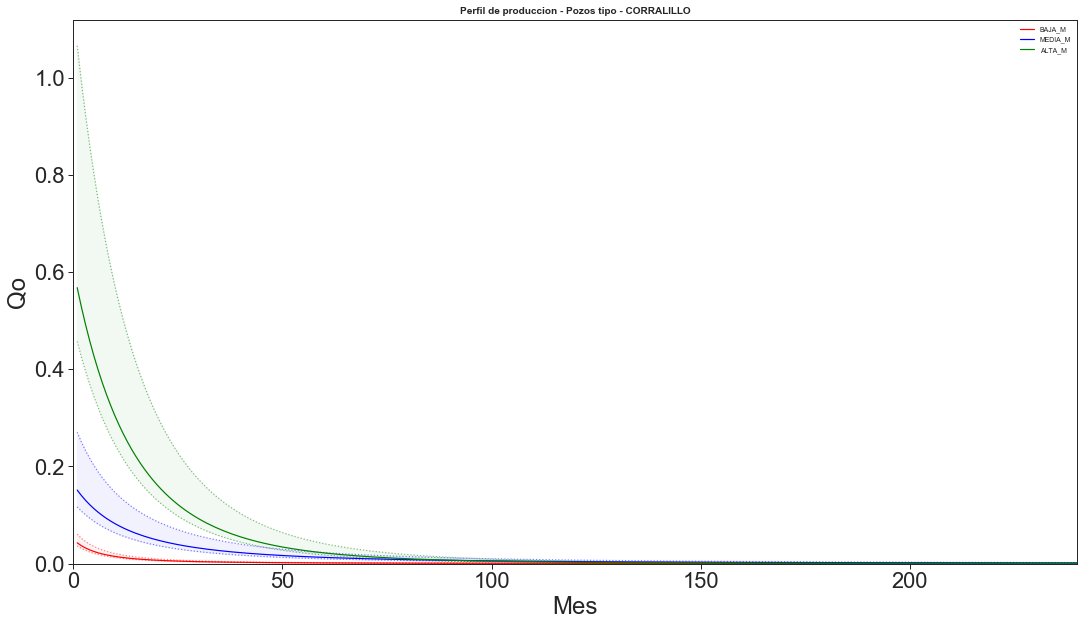

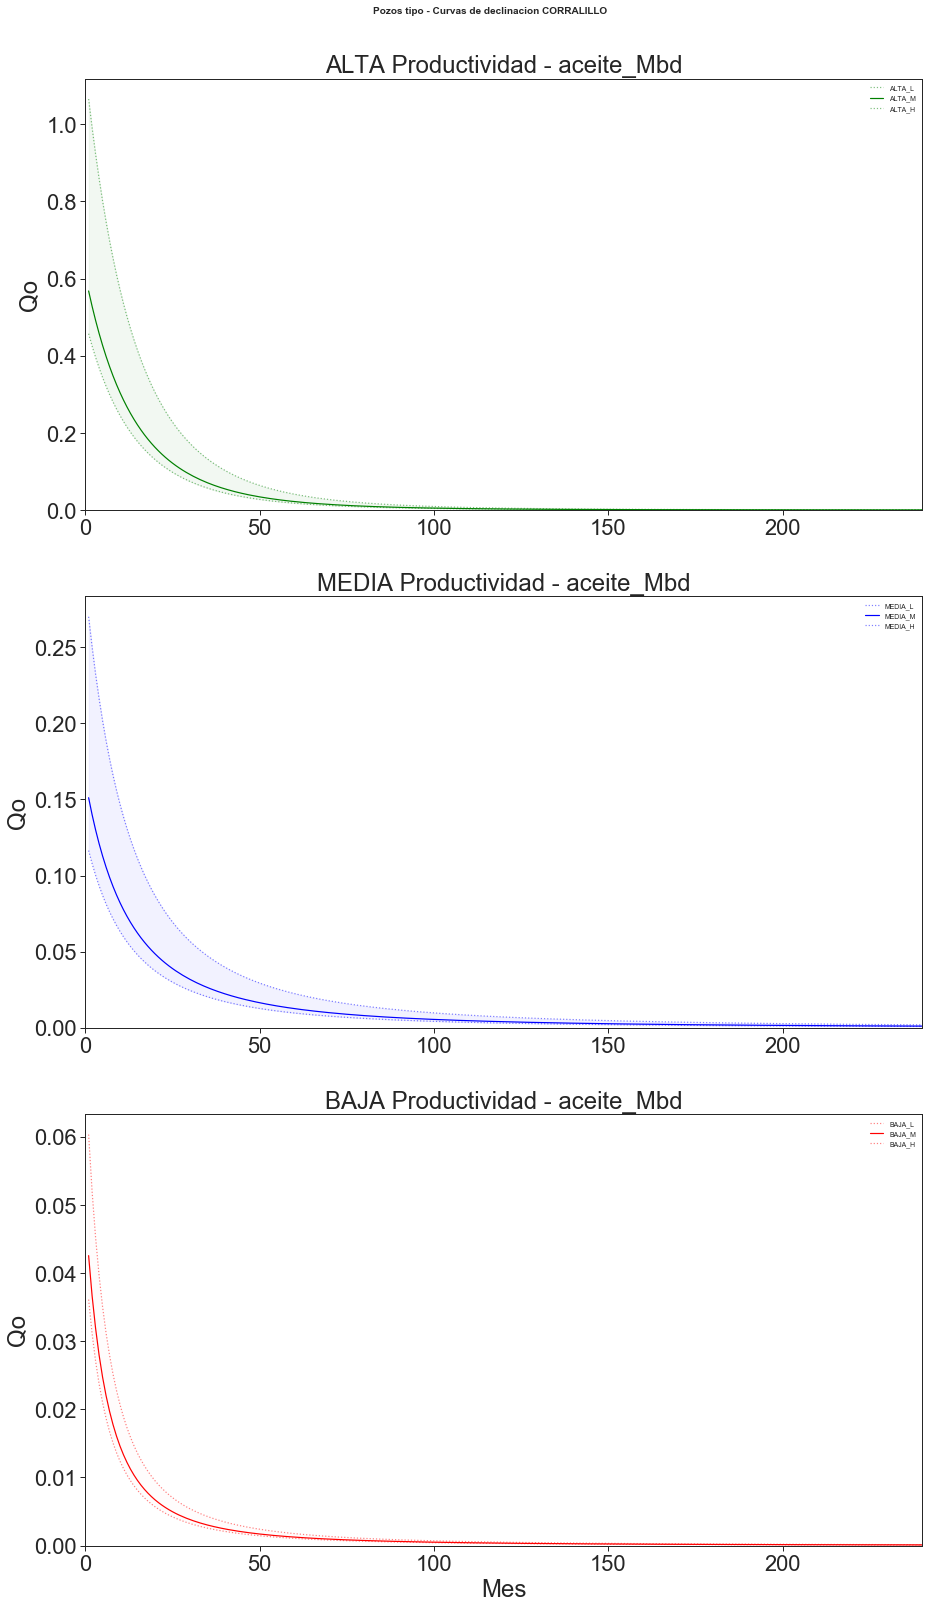

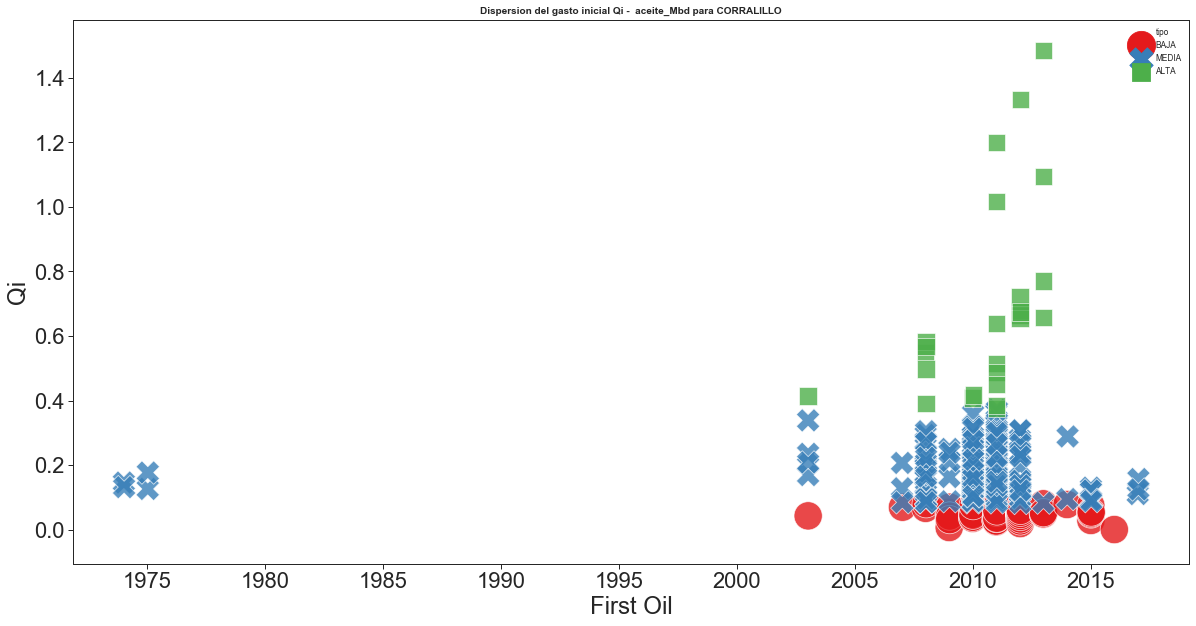

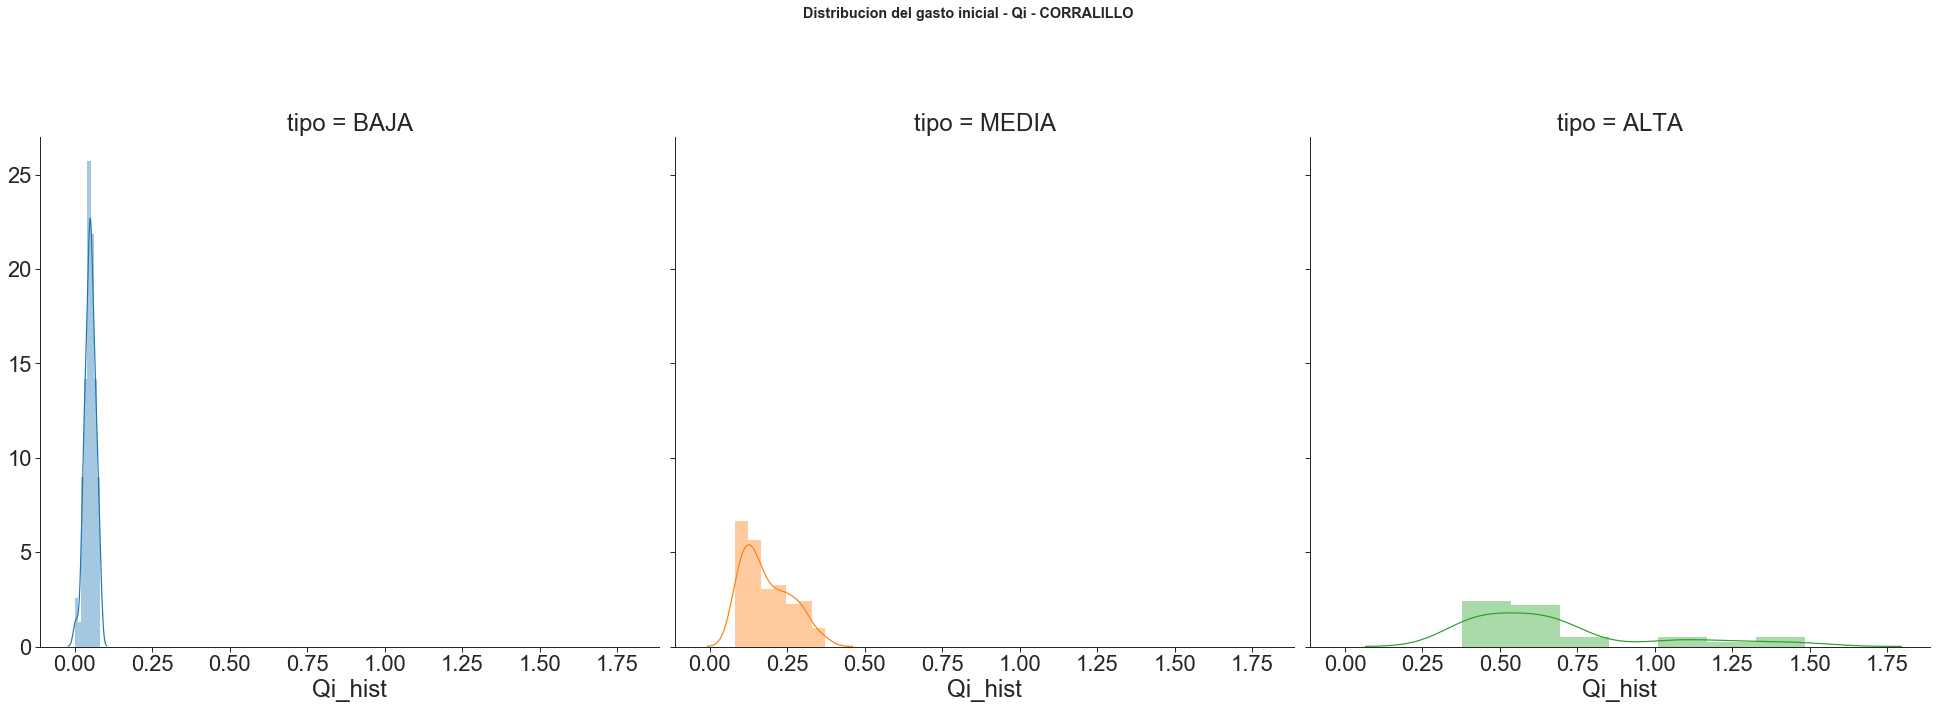

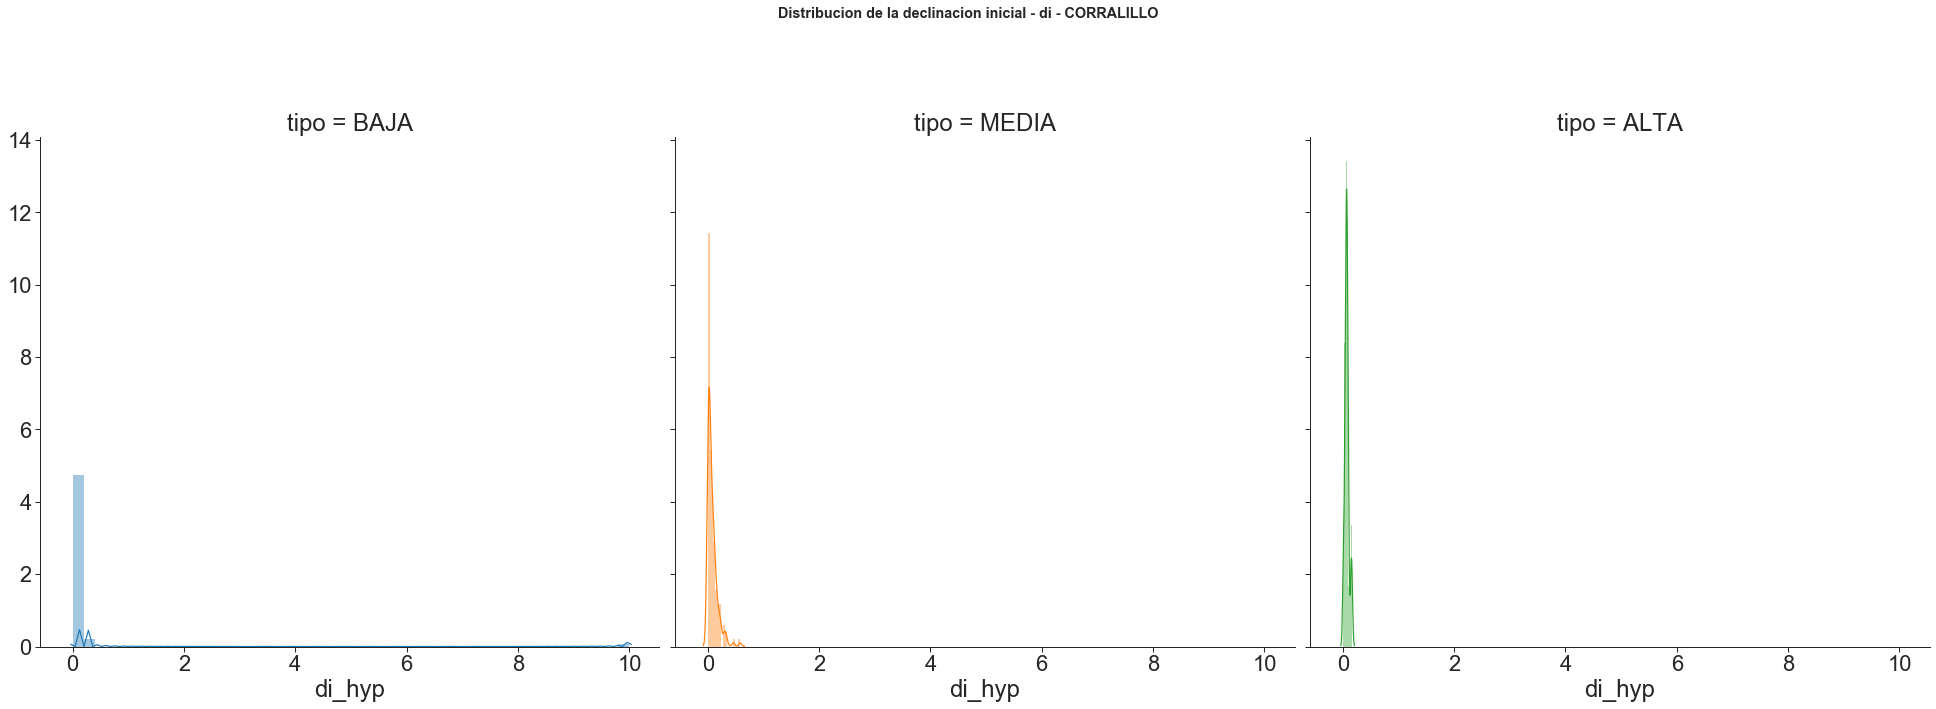

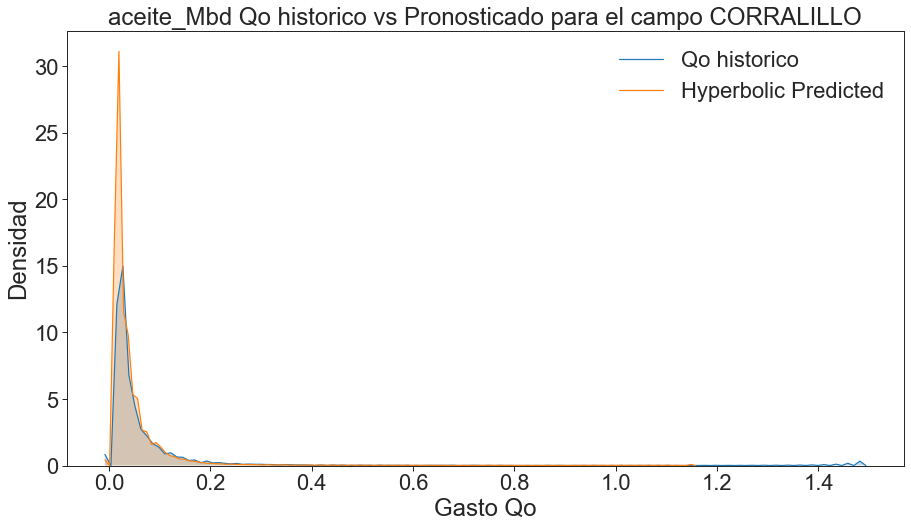

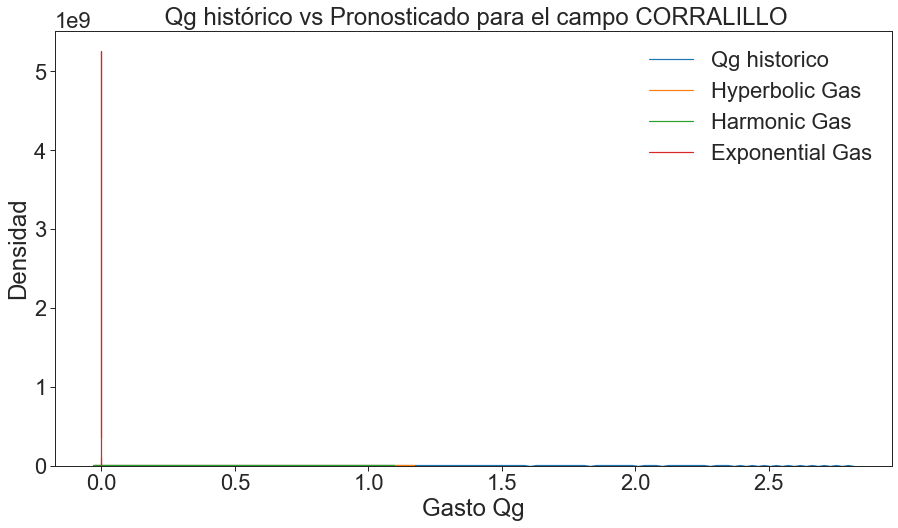

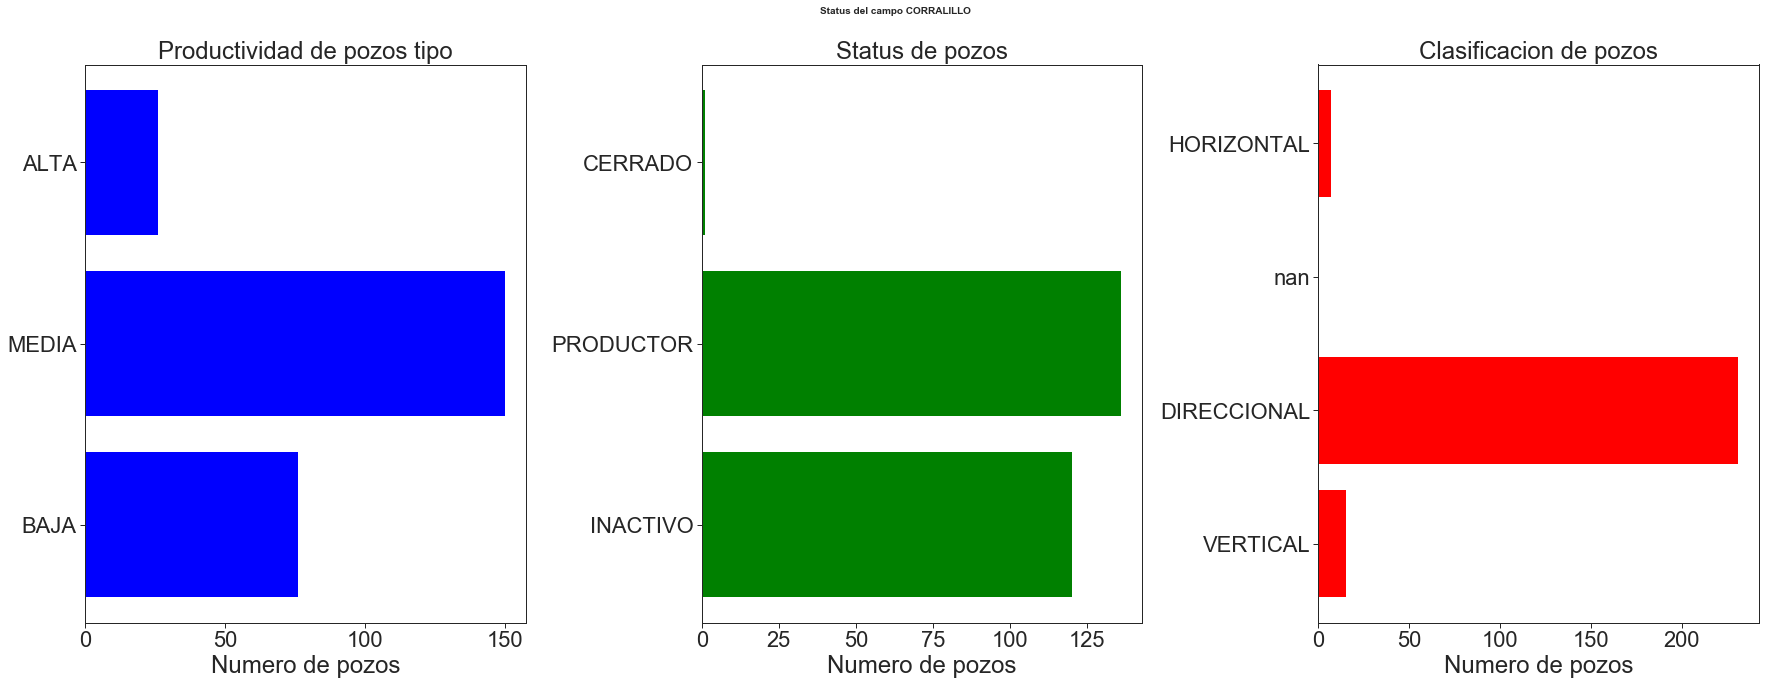

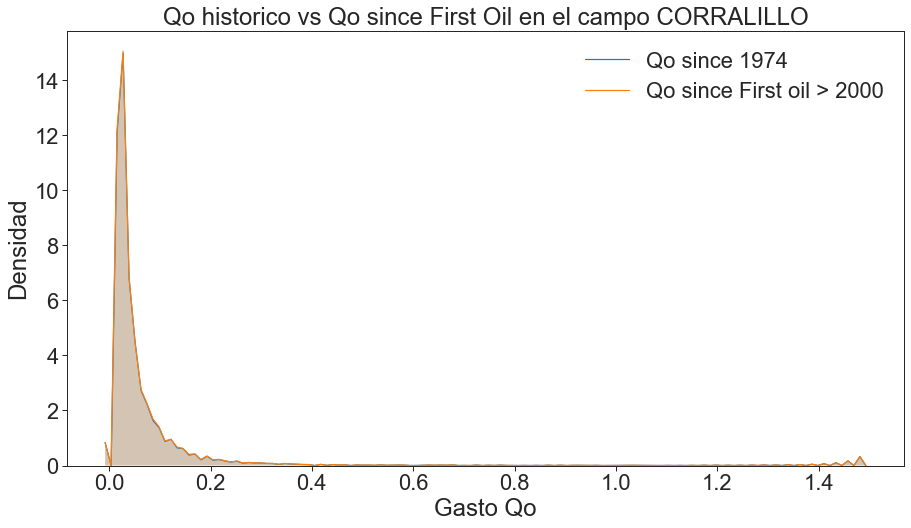

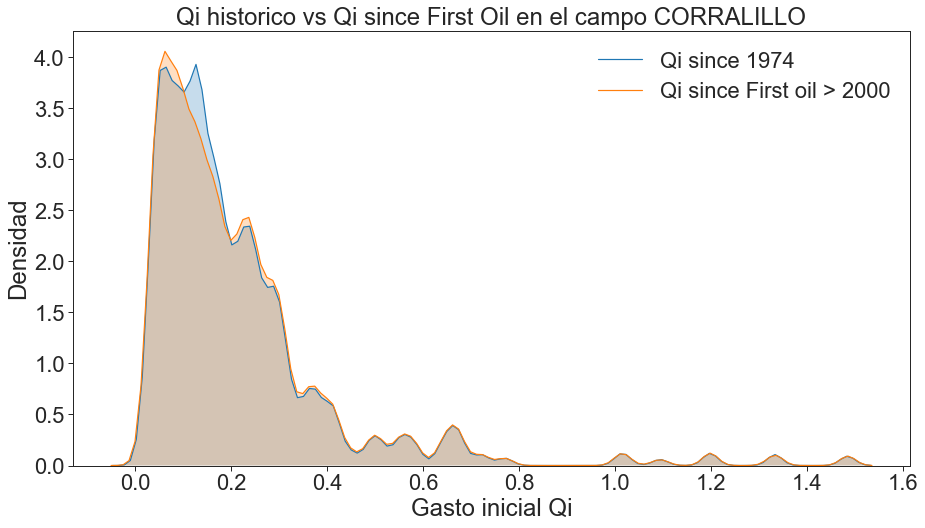

'Número de campos muestra para CORRALILLO: 83'

'Numero de campos analogos: 20'

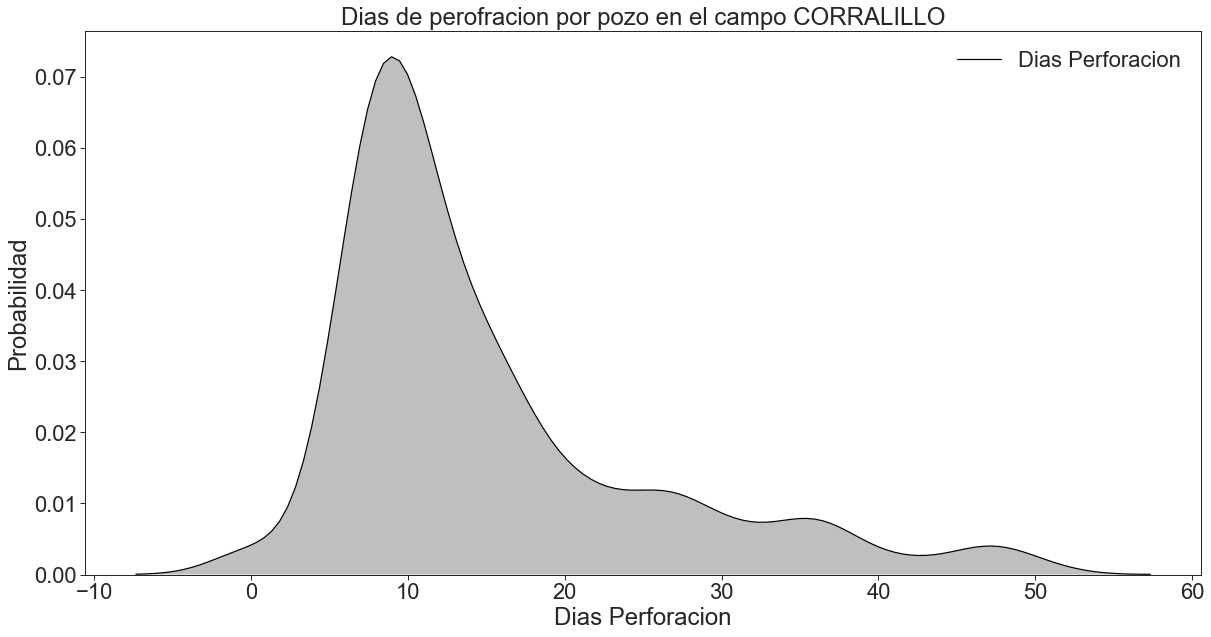

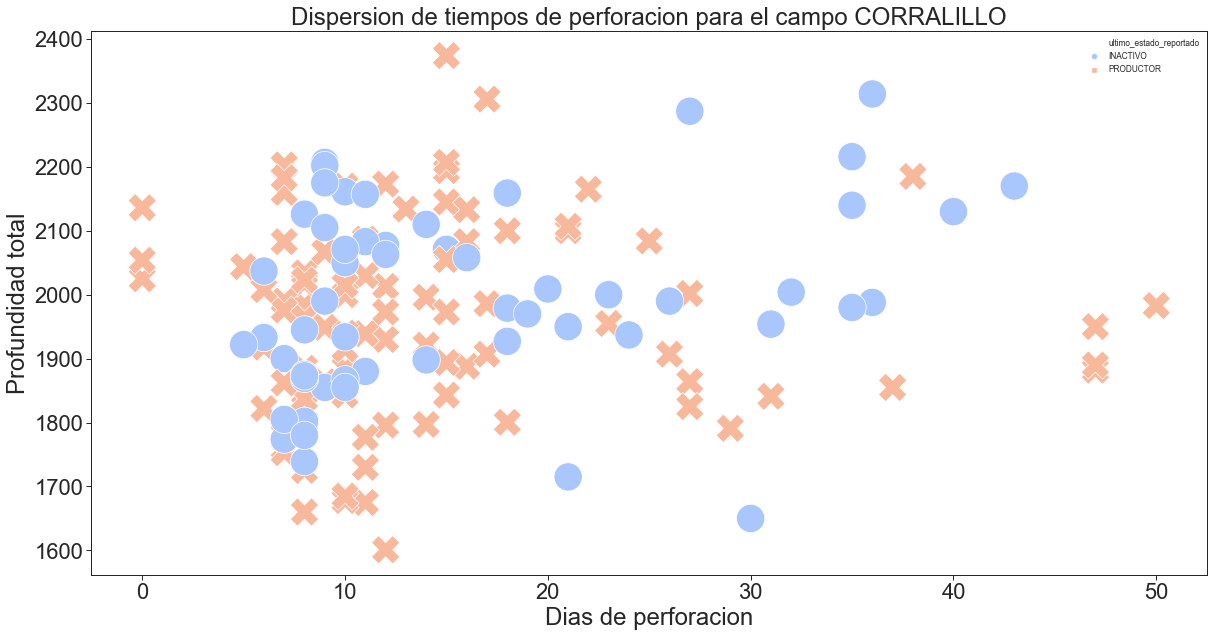

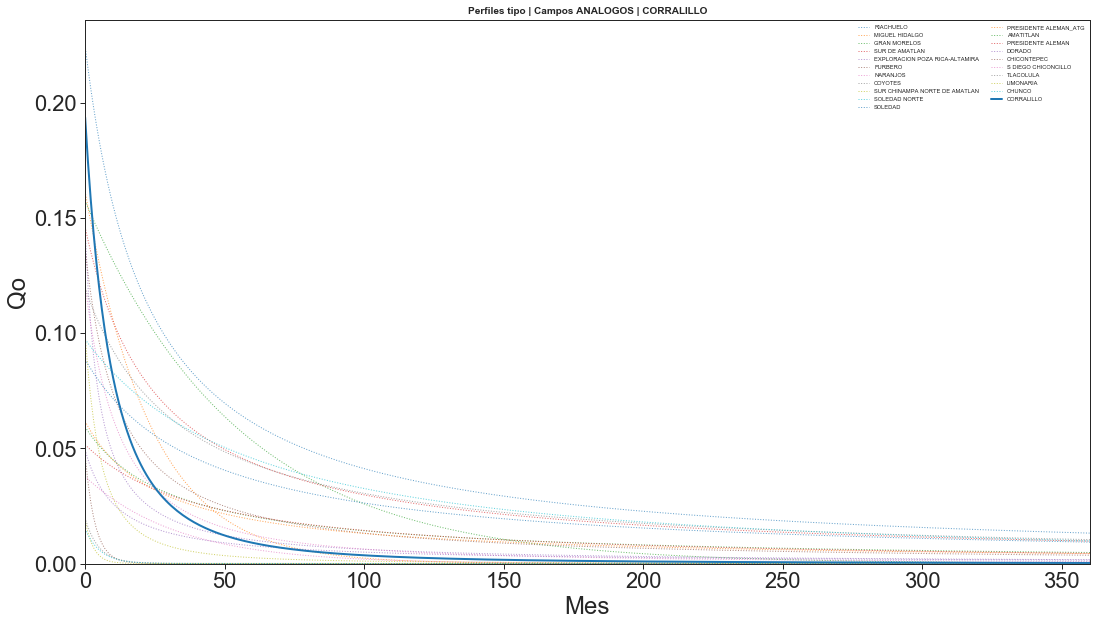

20

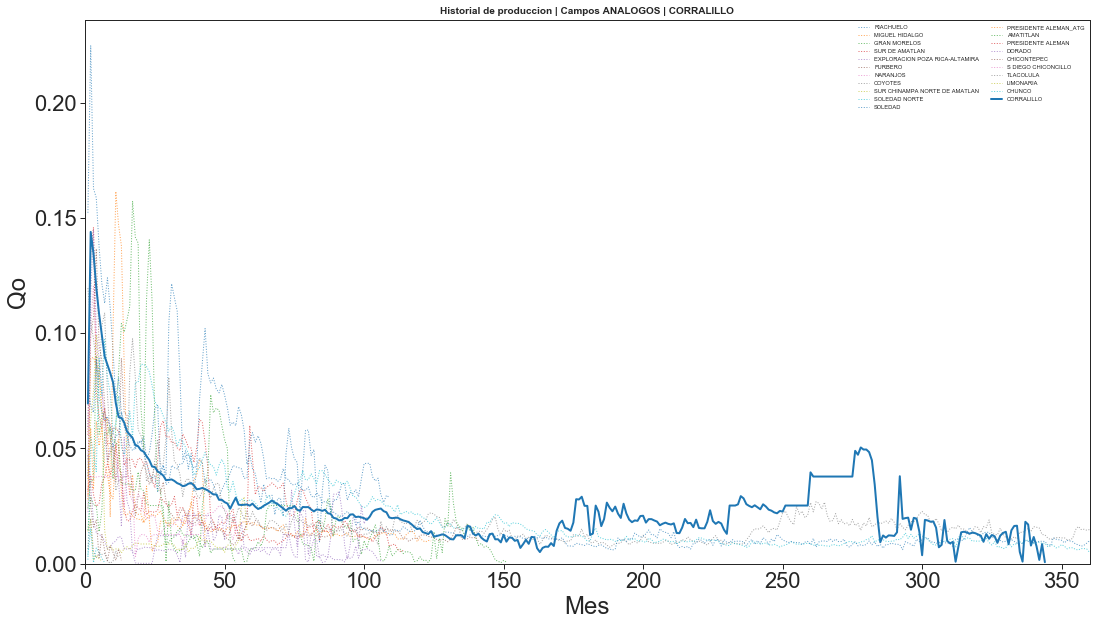

'Tiempo de procesamiento: 171.170631969 segundos'

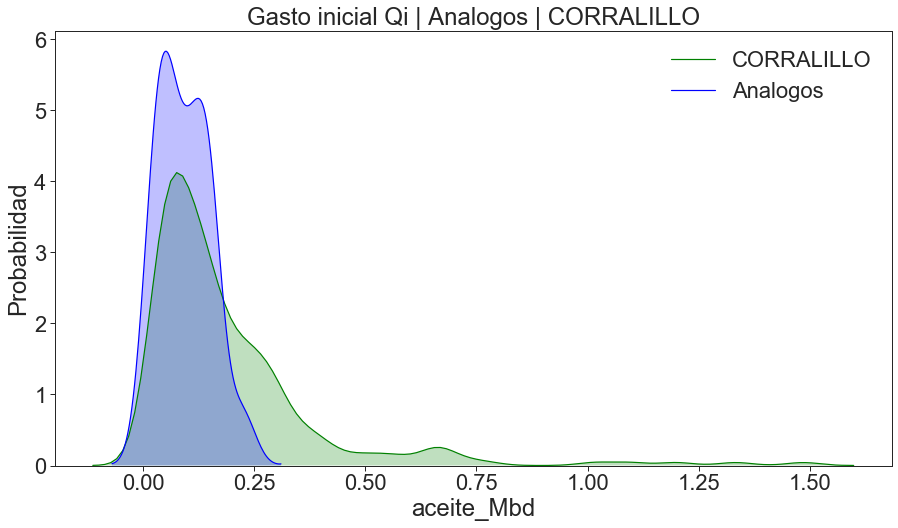

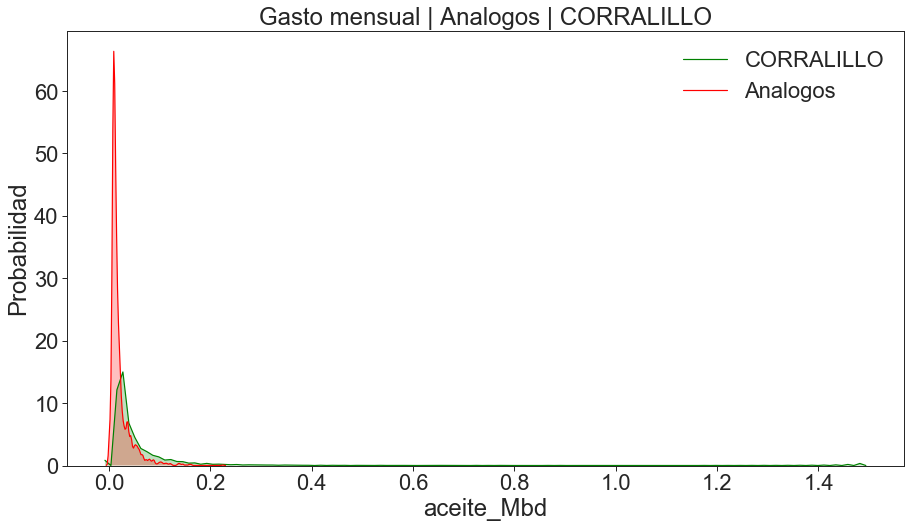

In [3]:
productividad()
#display(info_reservas)
#display(serie_base)
#display(len(lista_pozos),len(unique_well_list))
#display(resumen_produccion, produccion_mensual.head(),serie_status)